## Proyecto 3. Entrega 1
### Analsisis Exploratorio Violencia Intrafamiliar 
Diego Duarte 22075 - Jos√© Marchena 22398 - Andr√©s Kou 22305 - Esteban Zambrano 22119

In [136]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
import statsmodels.api as sm
import os

In [137]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Analisis de Variables

In [138]:
path = "./data/vif"
files = os.listdir(path)
print("Archivos en la carpeta:", files)

dfs = {file[:-4]: pd.read_csv(os.path.join(path, file)) for file in files if file.endswith(".csv")}

Archivos en la carpeta: ['VifAlfa.csv', 'VifAreaSexoEdad.csv', 'VifEscolaridad.csv', 'VifPuebloSexoRelacion.csv']


#### Funci√≥n para clasificar tipo de variable

In [139]:
def describir_dataset(df, nombre):
    print(f"\nAn√°lisis del dataset: {nombre}")
    print(f"Dimensiones: {df.shape[0]} filas, {df.shape[1]} columnas\n")
    
    tipos = df.dtypes
    resumen = []
    
    for col in df.columns:
        tipo = tipos[col]
        unicos = df[col].nunique()
        if tipo in ['int64', 'float64']:
            if unicos <= 20:
                clasificacion = "Categ√≥rica (n√∫merica)"
            else:
                clasificacion = "Cuantitativa"
        else:
            clasificacion = "Categ√≥rica"
        resumen.append((col, tipo, unicos, clasificacion))
    
    resumen_df = pd.DataFrame(resumen, columns=["Variable", "Tipo (dtype)", "Valores √∫nicos", "Clasificaci√≥n"])
    display(resumen_df)

for nombre, df in dfs.items():
    describir_dataset(df, nombre)



An√°lisis del dataset: VifAlfa
Dimensiones: 832 filas, 8 columnas



Variable Tipo (dtype)  Valores √∫nicos          Clasificaci√≥n
0     Grupos de edad       object              35             Categ√≥rica
1              Total       object             580             Categ√≥rica
2           Alfabeta       object             555             Categ√≥rica
3         Analfabeta       object             337             Categ√≥rica
4           Ignorado       object              68             Categ√≥rica
5               Sexo       object               2             Categ√≥rica
6  Victima o Agresor       object               2             Categ√≥rica
7               Anio        int64              13  Categ√≥rica (n√∫merica)


An√°lisis del dataset: VifAreaSexoEdad
Dimensiones: 452 filas, 15 columnas



Variable Tipo (dtype)  Valores √∫nicos  \
0   Grupos quinquenales de edad       object              24   
1                         Total        int64             401   
2                        TotalH       object             358   
3                        TotalM        int64             356   
4                         Urban        int64             381   
5                        UrbanH        int64             315   
6                        UrbanM        int64             329   
7                         Rural       object             372   
8                        RuralH       object             294   
9                        RuralM       object             307   
10                     Ignorado       object             193   
11                    IgnoradoH       object             146   
12                    IgnoradoM       object             145   
13            Victima o Agresor       object               2   
14                         Anio        int64              13   

            Clasificaci√≥n  
0              Categ√≥rica  
1            Cuantitativa  
2              Categ√≥rica  
3            Cuantitativa  
4            Cuantitativa  
5            Cuantitativa  
6            Cuantitativa  
7              Categ√≥rica  
8              Categ√≥rica  
9              Categ√≥rica  
10             Categ√≥rica  
11             Categ√≥rica  
12             Categ√≥rica  
13             Categ√≥rica  
14  Categ√≥rica (n√∫merica)


An√°lisis del dataset: VifEscolaridad
Dimensiones: 876 filas, 11 columnas



Variable Tipo (dtype)  Valores √∫nicos          Clasificaci√≥n
0     Grupo de edades       object              33             Categ√≥rica
1               Total       object             574             Categ√≥rica
2             Ninguno       object             338             Categ√≥rica
3            Primaria       object             452             Categ√≥rica
4              B√°sico       object             297             Categ√≥rica
5       Diversificado       object             311             Categ√≥rica
6       Universitario       object             146             Categ√≥rica
7            Ignorado       object             161             Categ√≥rica
8                Sexo       object               2             Categ√≥rica
9   Victima o Agresor       object               2             Categ√≥rica
10               Anio        int64              13  Categ√≥rica (n√∫merica)


An√°lisis del dataset: VifPuebloSexoRelacion
Dimensiones: 260 filas, 11 columnas



Variable Tipo (dtype)  Valores √∫nicos          Clasificaci√≥n
0      Relacion       object              10             Categ√≥rica
1         Total        int64             229           Cuantitativa
2   Ladinos(as)        int64             217           Cuantitativa
3         Mayas        int64             190           Cuantitativa
4     Gar√≠funas       object              21             Categ√≥rica
5        Xinkas       object              24             Categ√≥rica
6          Otro       object              51             Categ√≥rica
7     No indica        int64             137           Cuantitativa
8      Ignorado       object              69             Categ√≥rica
9          Sexo       object               2             Categ√≥rica
10         Anio        int64              13  Categ√≥rica (n√∫merica)

### Prueba de Normalidad

In [140]:
columnas_a_convertir = {
    "VifAlfa": ["Total", "Alfabeta", "Analfabeta", "Ignorado"],
    "VifAreaSexoEdad": ["Total", "UrbanM", "UrbanH", "Rural", "RuralM", "RuralH", "Ignorado", "IgnoradoH", "IgnoradoM", "TotalH"],
    "VifEscolaridad": ["Total", "Ninguno", "Primaria", "B√°sico", "Diversificado", "Universitario", "Ignorado"],
    "VifPuebloSexoRelacion": ["Gar√≠funas", "Xinkas", "Otro", "Ignorado"]
}

for name, df in dfs.items():
    if name in columnas_a_convertir:
        columnas = columnas_a_convertir[name] 

        # Reemplazar '-' por NaN antes de la conversi√≥n
        df[columnas] = df[columnas].replace("-", 0)

        # Convertir a num√©rico solo las columnas seleccionadas
        df[columnas] = df[columnas].apply(pd.to_numeric, errors="coerce")

        print(f"‚úÖ {name}: Columnas convertidas a num√©rico -> {columnas}")

‚úÖ VifAlfa: Columnas convertidas a num√©rico -> ['Total', 'Alfabeta', 'Analfabeta', 'Ignorado']
‚úÖ VifAreaSexoEdad: Columnas convertidas a num√©rico -> ['Total', 'UrbanM', 'UrbanH', 'Rural', 'RuralM', 'RuralH', 'Ignorado', 'IgnoradoH', 'IgnoradoM', 'TotalH']
‚úÖ VifEscolaridad: Columnas convertidas a num√©rico -> ['Total', 'Ninguno', 'Primaria', 'B√°sico', 'Diversificado', 'Universitario', 'Ignorado']
‚úÖ VifPuebloSexoRelacion: Columnas convertidas a num√©rico -> ['Gar√≠funas', 'Xinkas', 'Otro', 'Ignorado']


## Graficos exploratorios VIF

#### Edad

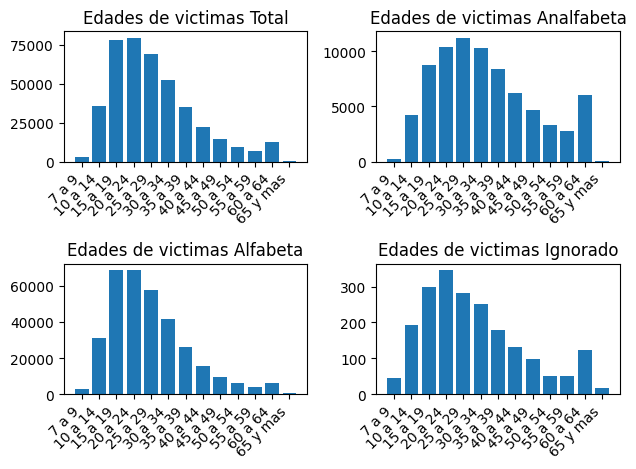

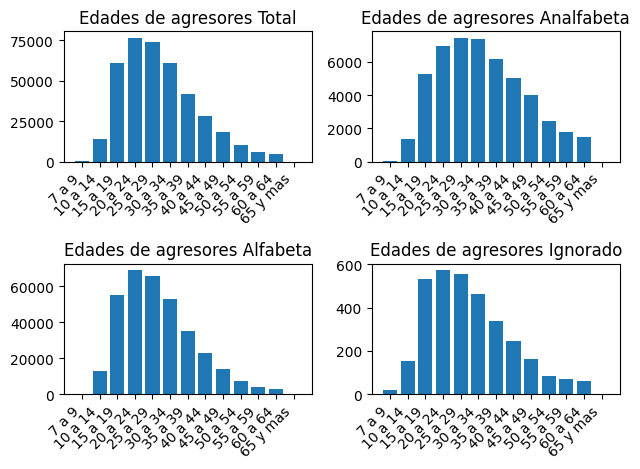

In [123]:
import warnings
warnings.simplefilter("ignore")
names = list(dfs.keys())
VifAlfa = dfs[names[0]]
t1 = VifAlfa[(VifAlfa["Grupos de edad"]!="Total") & 
             (VifAlfa["Grupos de edad"]!="Ignorado") &
             (VifAlfa["Grupos de edad"]!="Total Pa√≠s")]
# by_age = t1.groupby("Alfabeta")["Grupos de edad"].sum().reset_index()

t1['Grupos de edad'] = t1["Grupos de edad"].str.replace("a√±os", "", regex=False)
t1['Grupos de edad'] = t1["Grupos de edad"].str.replace(r"\s+", " ", regex=True).str.strip()
t1.loc[t1["Grupos de edad"]=="07 a 09", "Grupos de edad"] = "7 a 9"
t1.loc[t1["Grupos de edad"]=="07 a 09", "Grupos de edad"] = "5 a 9"

def simple_ages(age):
    try:
        if int(age) >= 7 and int(age) < 10:
            return "7 a 9"
        elif int(age) >= 10 and int(age) <= 14:
            return "10 a 14"
        else:
            return age
    except:
        if int(age.split(" ")[0])<7:
            return "7 a 9"
        elif int(age.split(" ")[0])>=65:
            return "65 y mas"
        return age

t1["Grupos de edad"] = t1["Grupos de edad"].apply(simple_ages)
ages = t1["Grupos de edad"].unique() 
fig, ax1 = plt.subplots(2, 2)
tvictims = t1.copy()
tvictims = tvictims[tvictims["Victima o Agresor"]=="V"]
for i, g in enumerate(["Total","Alfabeta","Analfabeta","Ignorado"]):
    tem = tvictims.groupby("Grupos de edad")[g].sum().reset_index()
    ax1[i%2,int(i/2)].set_title(f"Edades de victimas {g}")
    ax1[i%2,int(i/2)].bar(ages,tem[g])
    ax1[i%2,int(i/2)].set_xticklabels([f"{i}" for i in ages], rotation=45, ha="right")
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(2, 2)
taggressor= t1.copy()
taggressor = taggressor[taggressor["Victima o Agresor"]=="A"]
for i, g in enumerate(["Total","Alfabeta","Analfabeta","Ignorado"]):
    tem = taggressor.groupby("Grupos de edad")[g].sum().reset_index()
    ax2[i%2,int(i/2)].set_title(f"Edades de agresores {g}")
    ax2[i%2,int(i/2)].bar(ages,tem[g])
    ax2[i%2,int(i/2)].set_xticklabels([f"{i}" for i in ages], rotation=45, ha="right")
plt.tight_layout()
plt.show()

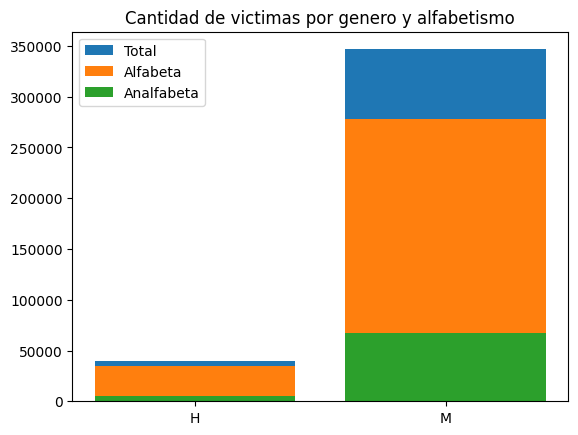

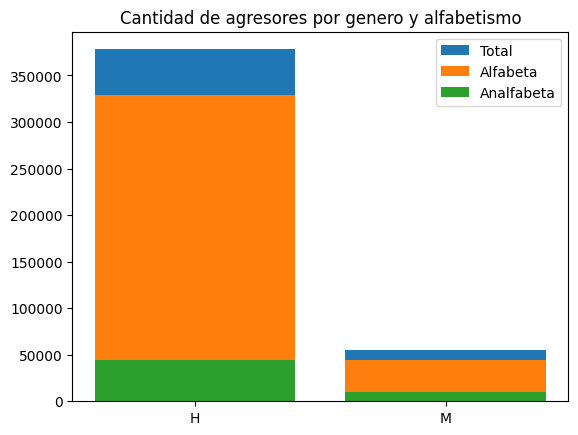

In [145]:
alf = VifAlfa.copy()
alf = alf[(alf["Grupos de edad"]=="Total")|
              (alf["Grupos de edad"]=="Todo el Pa√≠s")]
alf_v = alf[alf["Victima o Agresor"]=="V"]
alf_v = alf_v[["Total","Alfabeta","Analfabeta","Sexo"]]
alf_v_by_gender = alf_v.groupby("Sexo")["Total"].sum().reset_index()
for i,a in enumerate(["Total","Alfabeta","Analfabeta"]):
    tem = alf_v.groupby("Sexo")[a].sum().reset_index()
    plt.title("Cantidad de victimas por genero y alfabetismo")
    plt.bar(tem["Sexo"],tem[a],label=a)
    plt.legend()
plt.show()

alf_a = VifAlfa.copy()
alf_a = alf_a[alf_a["Victima o Agresor"]=="A"]
alf_a_total = alf_a.groupby(["Anio","Sexo"])[["Total","Alfabeta","Analfabeta"]].sum().reset_index()
alf_a_total
for i,a in enumerate(["Total","Alfabeta","Analfabeta"]):
    tem = alf_a_total.groupby("Sexo")[a].sum().reset_index()
    plt.title("Cantidad de agresores por genero y alfabetismo")
    plt.bar(tem["Sexo"],tem[a],label=a)
    plt.legend()
    


#### Relacion

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Esposos(as)'),
  Text(1, 0, 'Convivientes'),
  Text(2, 0, 'Ex c√≥nyuges'),
  Text(3, 0, 'Otro'),
  Text(4, 0, 'Hermanos(as)'),
  Text(5, 0, 'Padres/Madres'),
  Text(6, 0, 'Hijos(as)'),
  Text(7, 0, 'Suegros(as)'),
  Text(8, 0, 'Hijastros(as)'),
  Text(9, 0, 'Nietos(as)')])

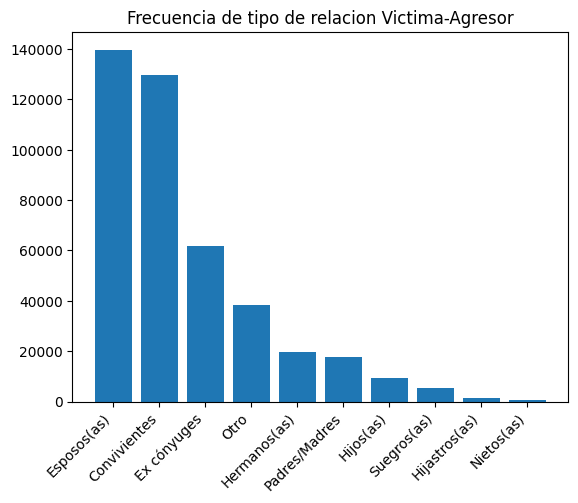

In [201]:
VifPSR = dfs[names[3]]
by_rel = VifPSR.groupby("Relacion")["Total"].sum().reset_index()
by_rel= by_rel.sort_values(by="Total",ascending=False)
plt.title("Frecuencia de tipo de relacion Victima-Agresor")
plt.bar(by_rel["Relacion"],by_rel["Total"])
plt.xticks(rotation=45,ha='right')

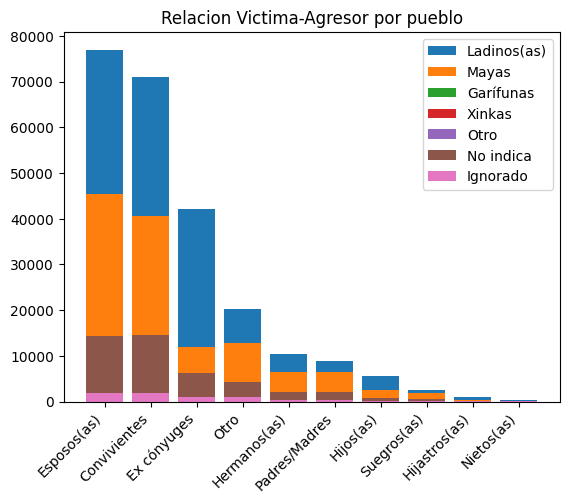

In [202]:
pueblos = list(VifPSR.columns)
pueblos = pueblos[2:]
pueblos = pueblos[:-2]
for p in pueblos:
    by_rel = VifPSR.groupby("Relacion")[p].sum().reset_index()
    by_rel= by_rel.sort_values(by=p,ascending=False)
    plt.title("Relacion Victima-Agresor por pueblo")
    plt.bar(by_rel["Relacion"],by_rel[p], label=p)
    plt.legend()
    plt.xticks(rotation=45,ha='right',)
    

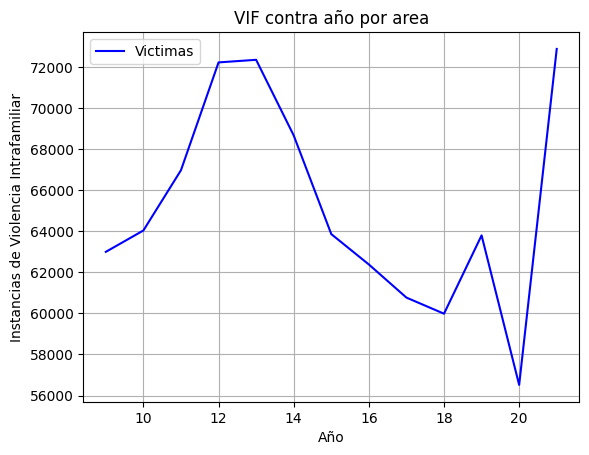

In [203]:
VifASE = dfs[names[1]]
ase_no_age = VifASE.groupby(["Anio","Victima o Agresor"])[["Total","Urban","Rural","Ignorado"]].sum().reset_index()
ase_v = ase_no_age[ase_no_age["Victima o Agresor"]=="V"]
plt.plot(ase_v["Anio"], ase_v["Total"],label='Victimas', color='blue')
plt.legend()
plt.title("VIF contra a√±o por area")
plt.ylabel("Instancias de Violencia Intrafamiliar")
plt.xlabel("A√±o")
plt.grid()

********************************************************************************************

üîπ **Analizando archivo: VifAlfa**

‚ö†Ô∏è La columna 'Total' tiene 5 ceros en el archivo 'VifAlfa'.
Estad√≠stico de prueba (ks_statistic) = 0.30346553309488066841
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAlfa - Total' NO provienen de una distribuci√≥n normal.



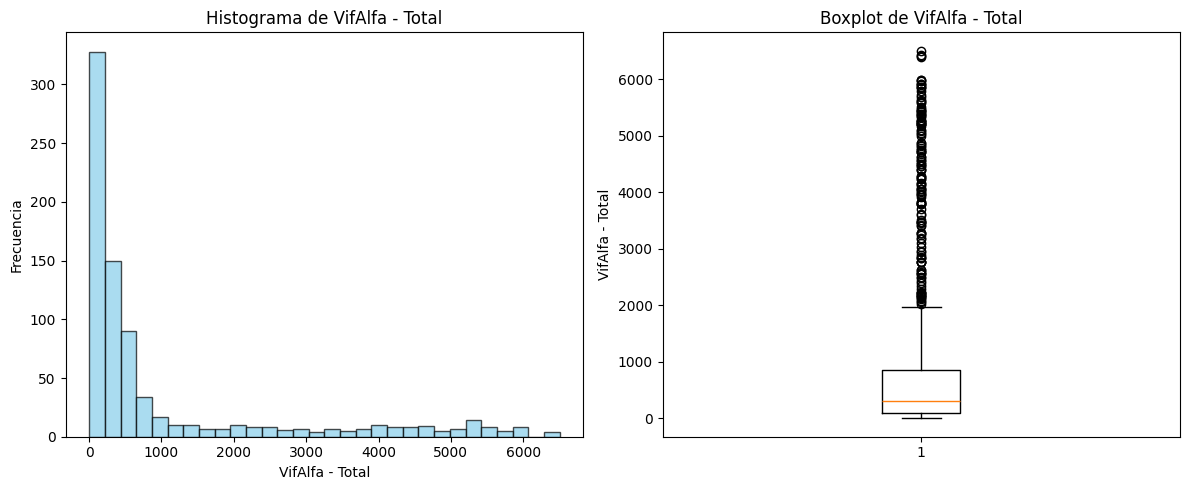

‚ö†Ô∏è La columna 'Alfabeta' tiene 7 ceros en el archivo 'VifAlfa'.
Estad√≠stico de prueba (ks_statistic) = 0.31109965277739237699
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAlfa - Alfabeta' NO provienen de una distribuci√≥n normal.



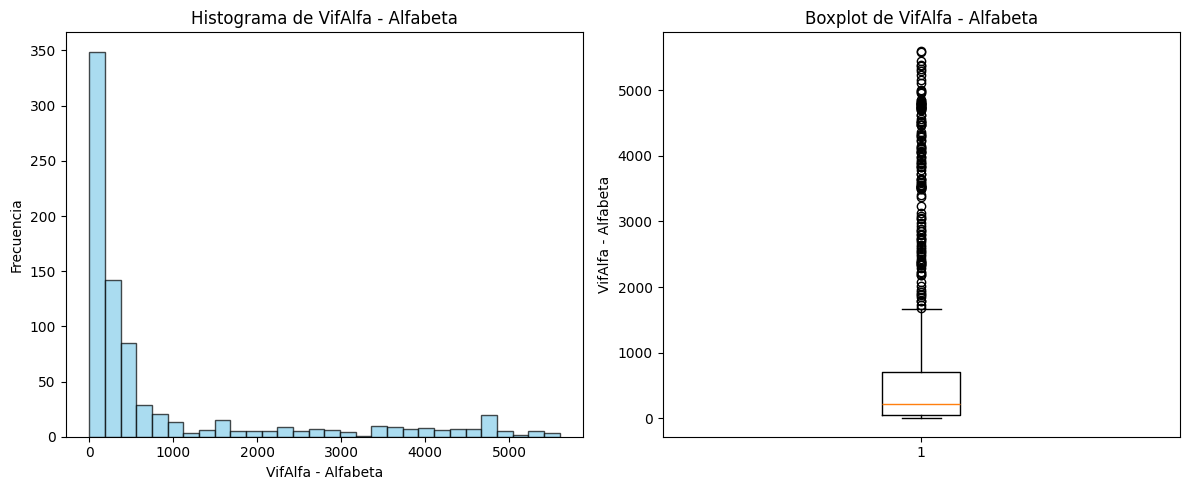

‚ö†Ô∏è La columna 'Analfabeta' tiene 39 ceros en el archivo 'VifAlfa'.
Estad√≠stico de prueba (ks_statistic) = 0.26049970997823035379
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAlfa - Analfabeta' NO provienen de una distribuci√≥n normal.



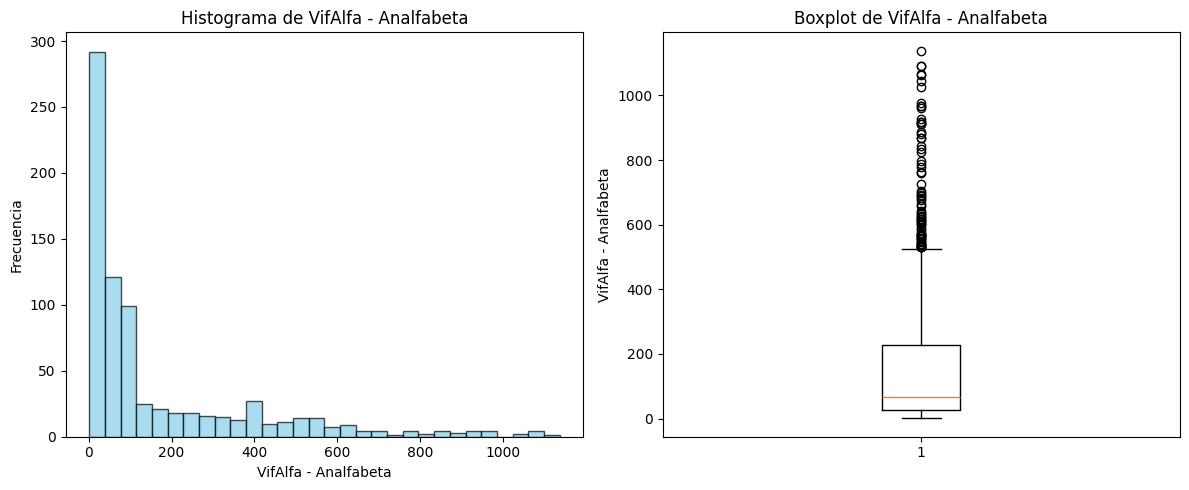

‚ö†Ô∏è La columna 'Ignorado' tiene 183 ceros en el archivo 'VifAlfa'.
Estad√≠stico de prueba (ks_statistic) = 0.36361010098313217842
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAlfa - Ignorado' NO provienen de una distribuci√≥n normal.



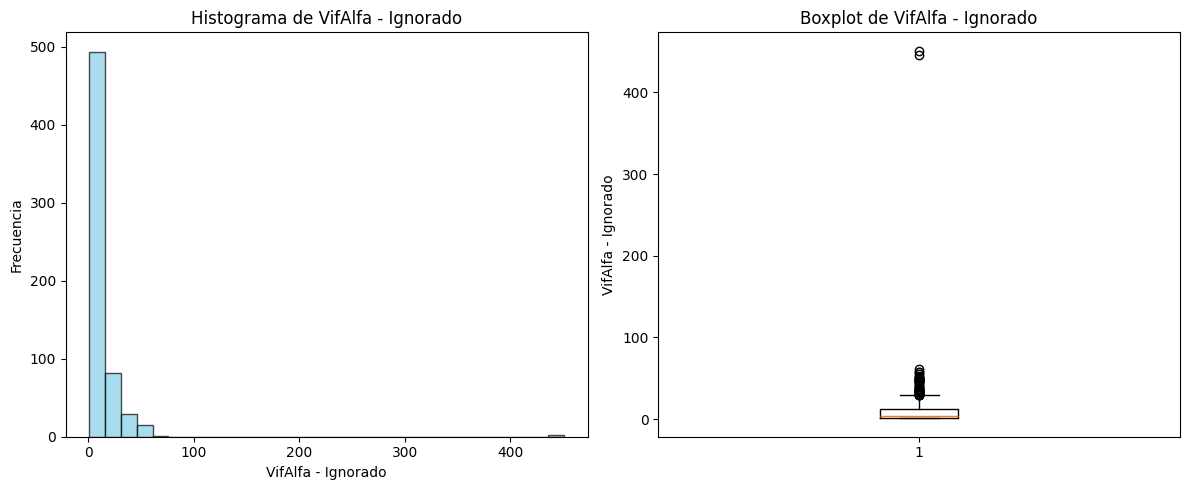

********************************************************************************************

üîπ **Analizando archivo: VifAreaSexoEdad**

Estad√≠stico de prueba (ks_statistic) = 0.18704383510634464693
p-value = 0.00000000000014952987
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - Total' NO provienen de una distribuci√≥n normal.



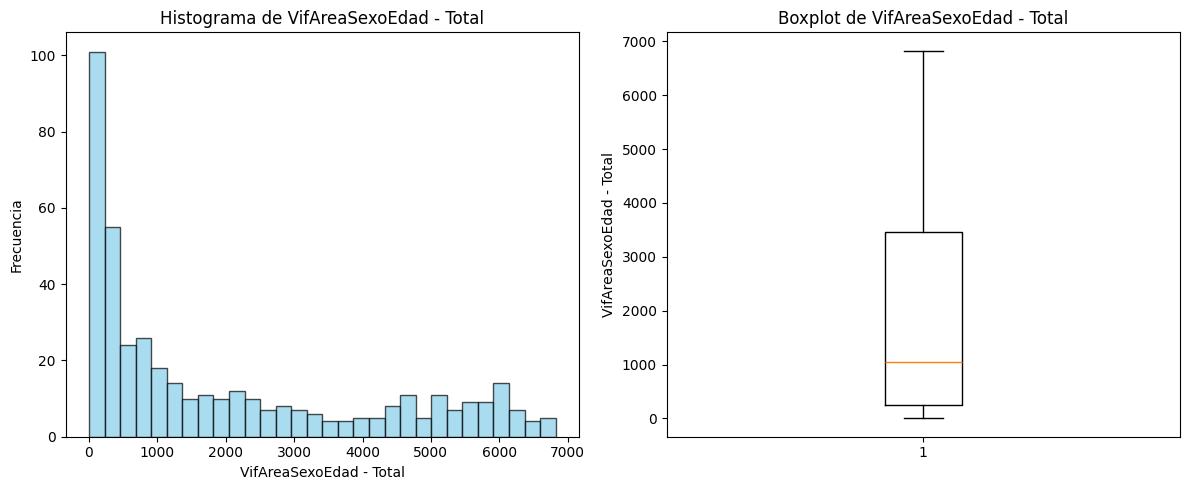

‚ö†Ô∏è La columna 'TotalH' tiene 1 ceros en el archivo 'VifAreaSexoEdad'.
Estad√≠stico de prueba (ks_statistic) = 0.30045315270194727919
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - TotalH' NO provienen de una distribuci√≥n normal.



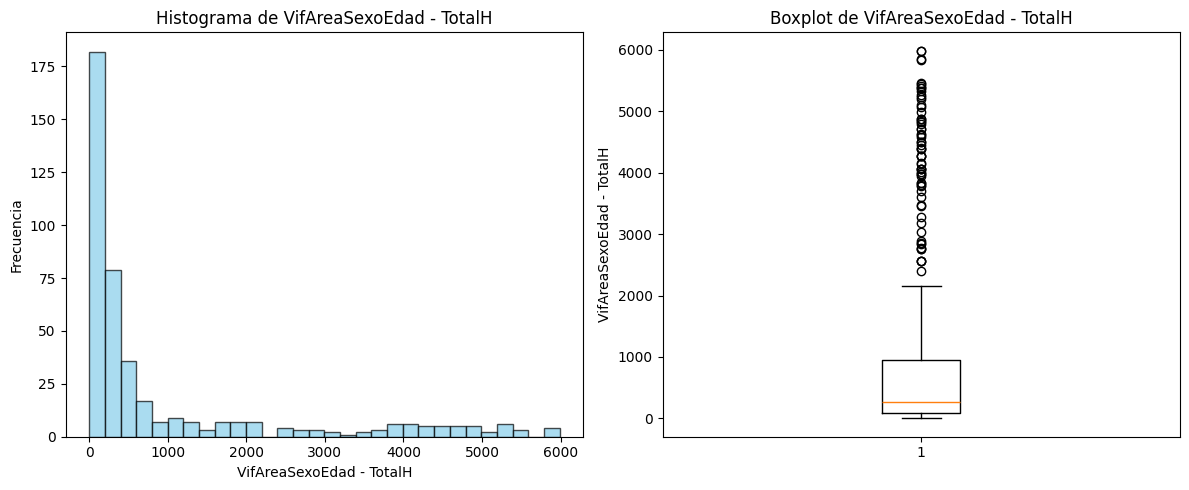

‚ö†Ô∏è La columna 'TotalM' tiene 4 ceros en el archivo 'VifAreaSexoEdad'.
Estad√≠stico de prueba (ks_statistic) = 0.30695266376276220122
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - TotalM' NO provienen de una distribuci√≥n normal.



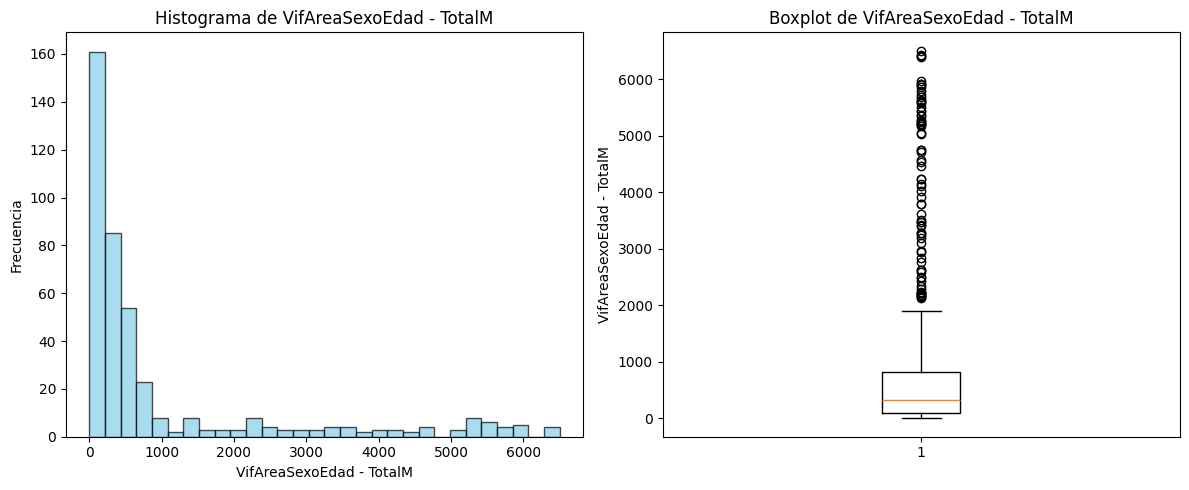

‚ö†Ô∏è La columna 'Urban' tiene 1 ceros en el archivo 'VifAreaSexoEdad'.
Estad√≠stico de prueba (ks_statistic) = 0.18599368318937914424
p-value = 0.00000000000022534665
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - Urban' NO provienen de una distribuci√≥n normal.



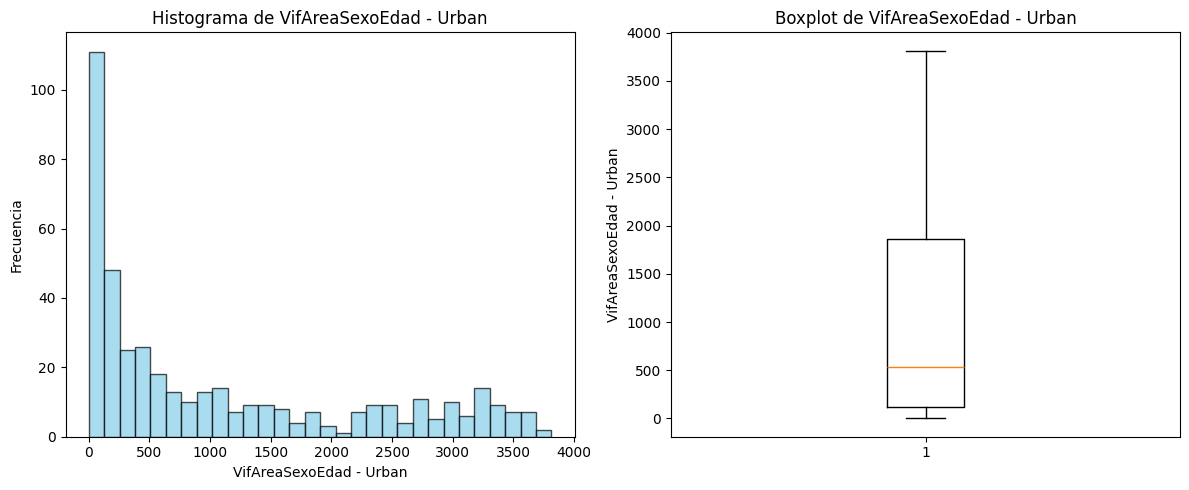

‚ö†Ô∏è La columna 'UrbanH' tiene 2 ceros en el archivo 'VifAreaSexoEdad'.
Estad√≠stico de prueba (ks_statistic) = 0.30020542476148992517
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - UrbanH' NO provienen de una distribuci√≥n normal.



‚ö†Ô∏è La columna 'UrbanM' tiene 4 ceros en el archivo 'VifAreaSexoEdad'.
Estad√≠stico de prueba (ks_statistic) = 0.30305666769737421573
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - UrbanM' NO provienen de una distribuci√≥n normal.



‚ö†Ô∏è La columna 'Rural' tiene 3 ceros en el archivo 'VifAreaSexoEdad'.
Estad√≠stico de prueba (ks_statistic) = 0.17517289164811161717
p-value = 0.00000000000752643278
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - Rural' NO provienen de una distribuci√≥n normal.



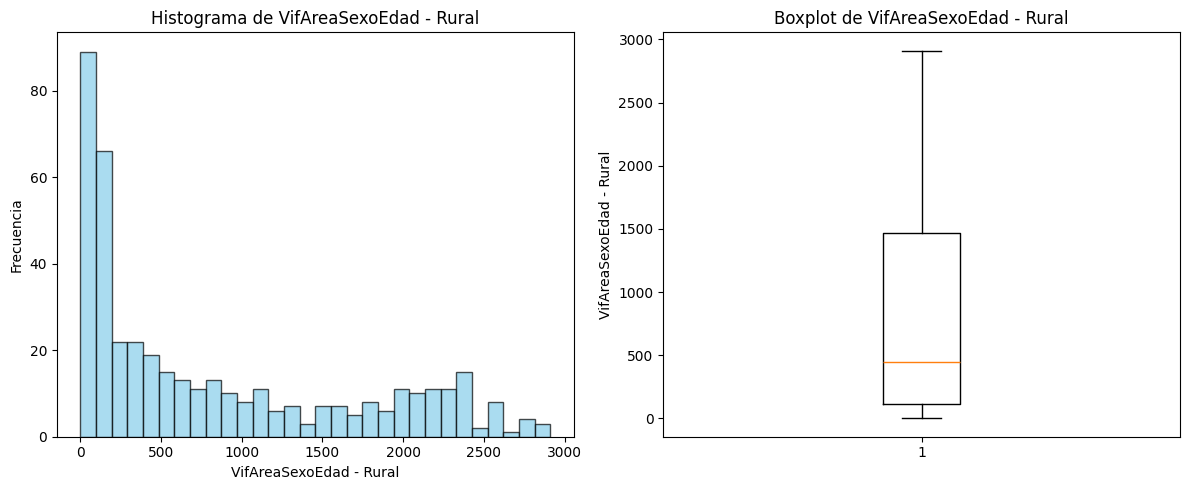

‚ö†Ô∏è La columna 'RuralH' tiene 3 ceros en el archivo 'VifAreaSexoEdad'.
Estad√≠stico de prueba (ks_statistic) = 0.29471984496539871401
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - RuralH' NO provienen de una distribuci√≥n normal.



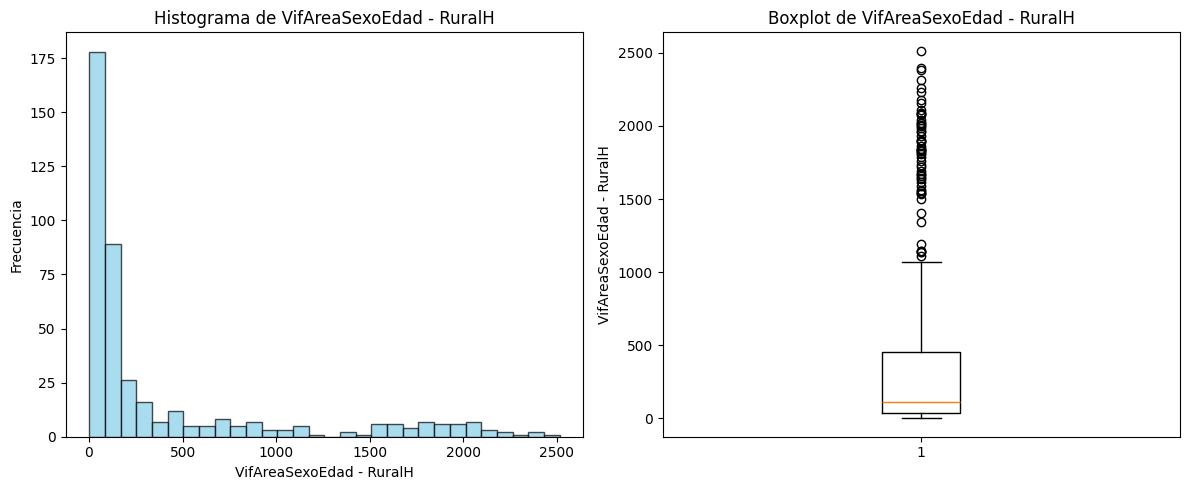

‚ö†Ô∏è La columna 'RuralM' tiene 8 ceros en el archivo 'VifAreaSexoEdad'.
Estad√≠stico de prueba (ks_statistic) = 0.30771411138028303967
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - RuralM' NO provienen de una distribuci√≥n normal.



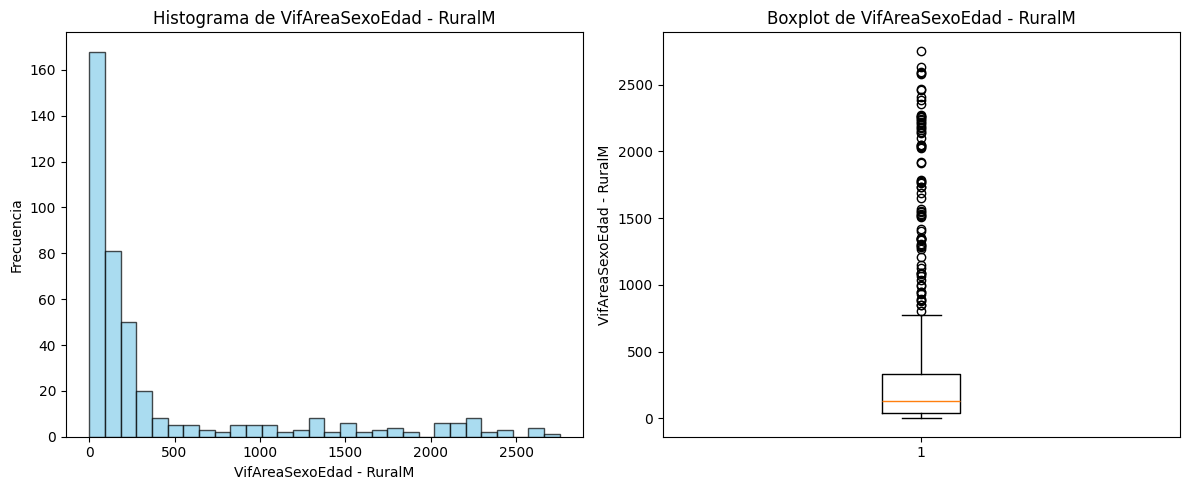

‚ö†Ô∏è La columna 'Ignorado' tiene 23 ceros en el archivo 'VifAreaSexoEdad'.
Estad√≠stico de prueba (ks_statistic) = 0.21701054598410784990
p-value = 0.00000000000000003496
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - Ignorado' NO provienen de una distribuci√≥n normal.



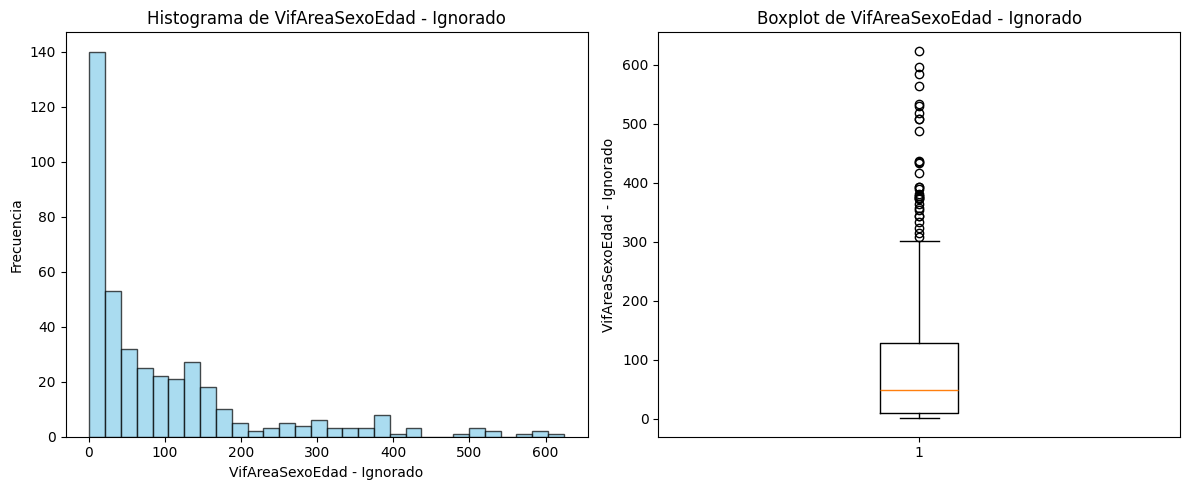

‚ö†Ô∏è La columna 'IgnoradoH' tiene 36 ceros en el archivo 'VifAreaSexoEdad'.
Estad√≠stico de prueba (ks_statistic) = 0.29134308958891785846
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - IgnoradoH' NO provienen de una distribuci√≥n normal.



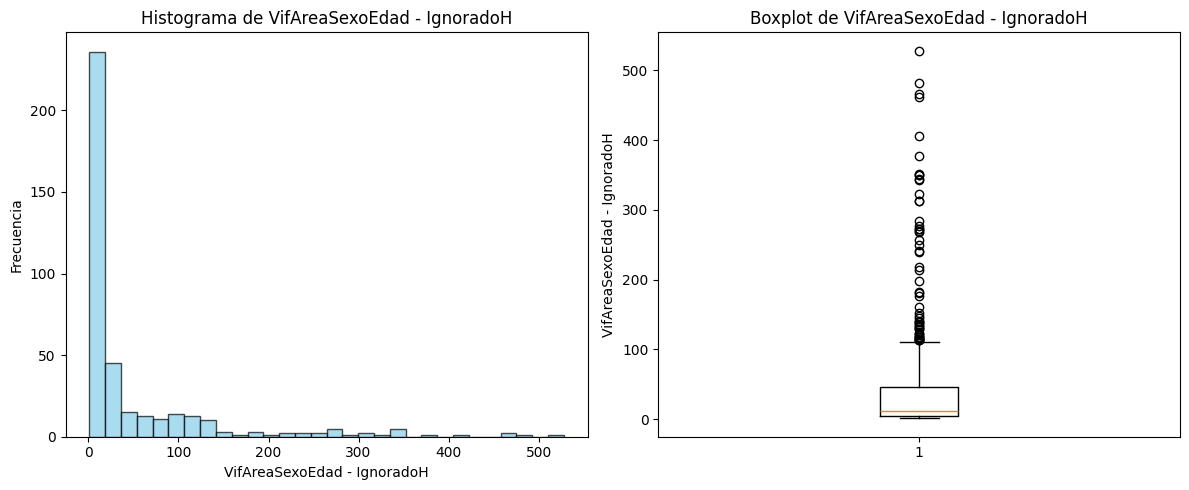

‚ö†Ô∏è La columna 'IgnoradoM' tiene 51 ceros en el archivo 'VifAreaSexoEdad'.
Estad√≠stico de prueba (ks_statistic) = 0.29082343522153486504
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifAreaSexoEdad - IgnoradoM' NO provienen de una distribuci√≥n normal.



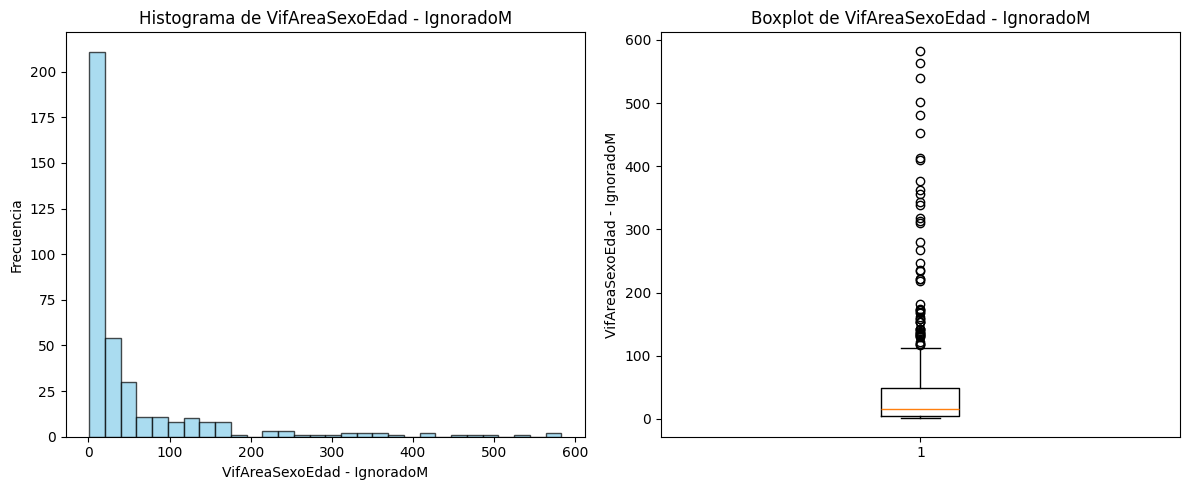

********************************************************************************************

üîπ **Analizando archivo: VifEscolaridad**

‚ö†Ô∏è La columna 'Total' tiene 5 ceros en el archivo 'VifEscolaridad'.
Estad√≠stico de prueba (ks_statistic) = 0.30318588077079811072
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifEscolaridad - Total' NO provienen de una distribuci√≥n normal.



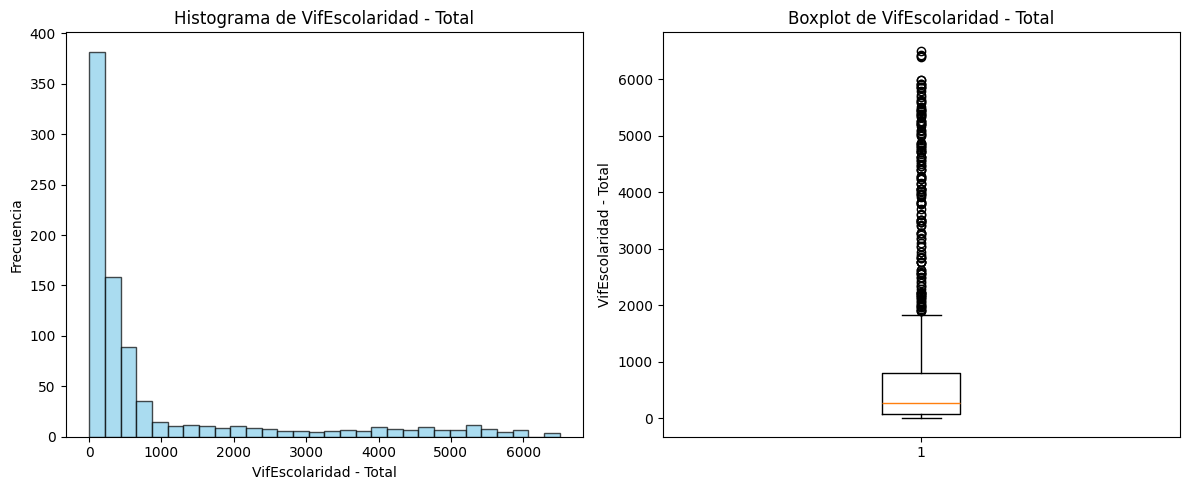

‚ö†Ô∏è La columna 'Ninguno' tiene 36 ceros en el archivo 'VifEscolaridad'.
Estad√≠stico de prueba (ks_statistic) = 0.27522871985761571123
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifEscolaridad - Ninguno' NO provienen de una distribuci√≥n normal.



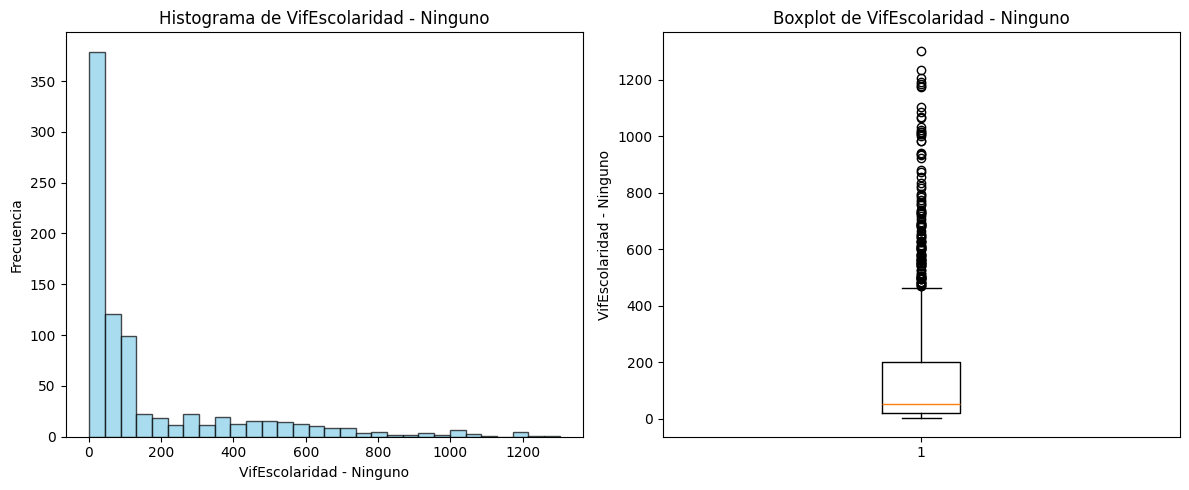

‚ö†Ô∏è La columna 'Primaria' tiene 11 ceros en el archivo 'VifEscolaridad'.
Estad√≠stico de prueba (ks_statistic) = 0.29987947860417785151
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifEscolaridad - Primaria' NO provienen de una distribuci√≥n normal.



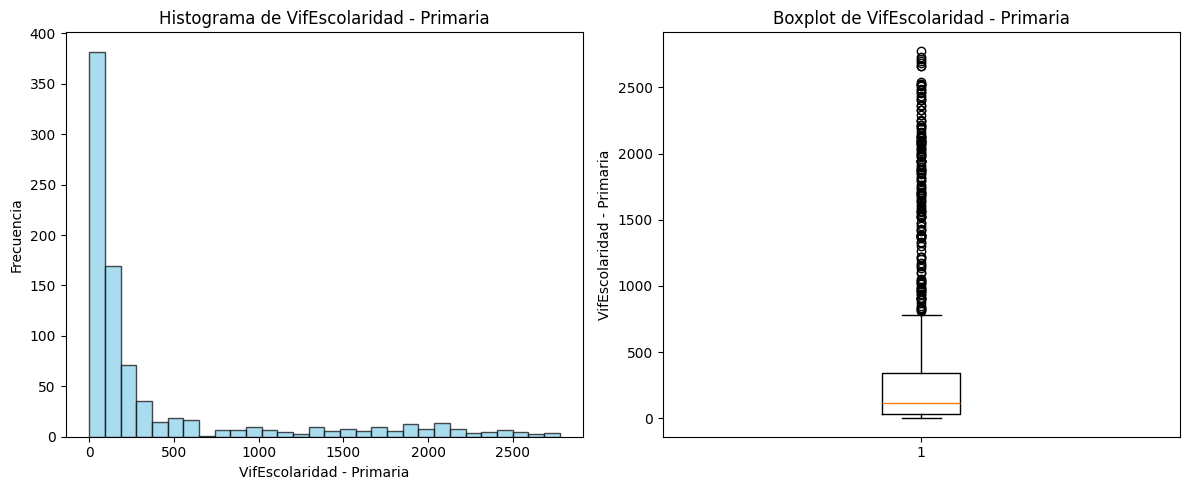

‚ö†Ô∏è La columna 'B√°sico' tiene 95 ceros en el archivo 'VifEscolaridad'.
Estad√≠stico de prueba (ks_statistic) = 0.30944844562310136471
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifEscolaridad - B√°sico' NO provienen de una distribuci√≥n normal.



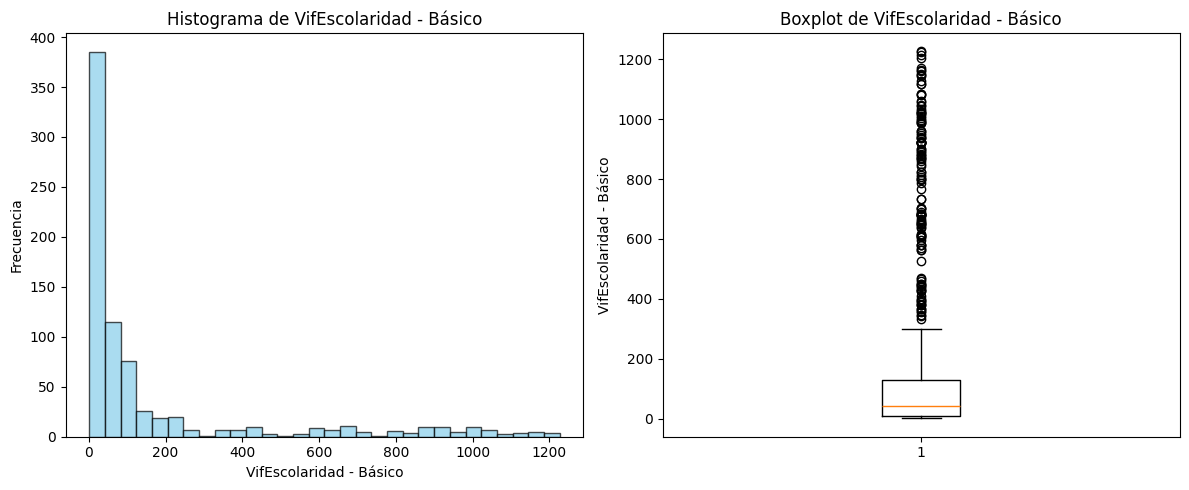

‚ö†Ô∏è La columna 'Diversificado' tiene 148 ceros en el archivo 'VifEscolaridad'.
Estad√≠stico de prueba (ks_statistic) = 0.30062545296779369375
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifEscolaridad - Diversificado' NO provienen de una distribuci√≥n normal.



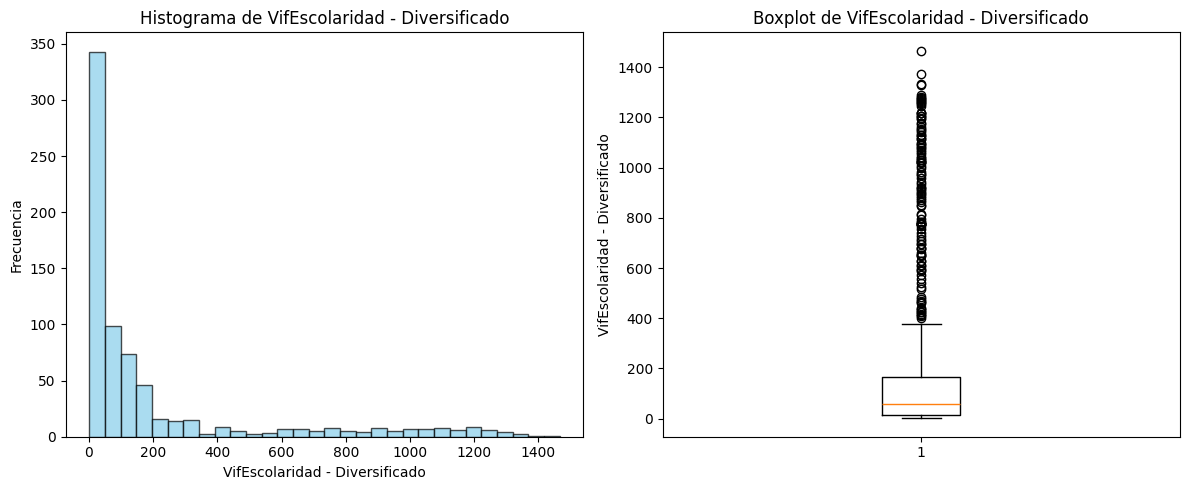

‚ö†Ô∏è La columna 'Universitario' tiene 210 ceros en el archivo 'VifEscolaridad'.
Estad√≠stico de prueba (ks_statistic) = 0.25769583780657856487
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifEscolaridad - Universitario' NO provienen de una distribuci√≥n normal.



‚ö†Ô∏è La columna 'Ignorado' tiene 106 ceros en el archivo 'VifEscolaridad'.
Estad√≠stico de prueba (ks_statistic) = 0.32512134417317395396
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifEscolaridad - Ignorado' NO provienen de una distribuci√≥n normal.



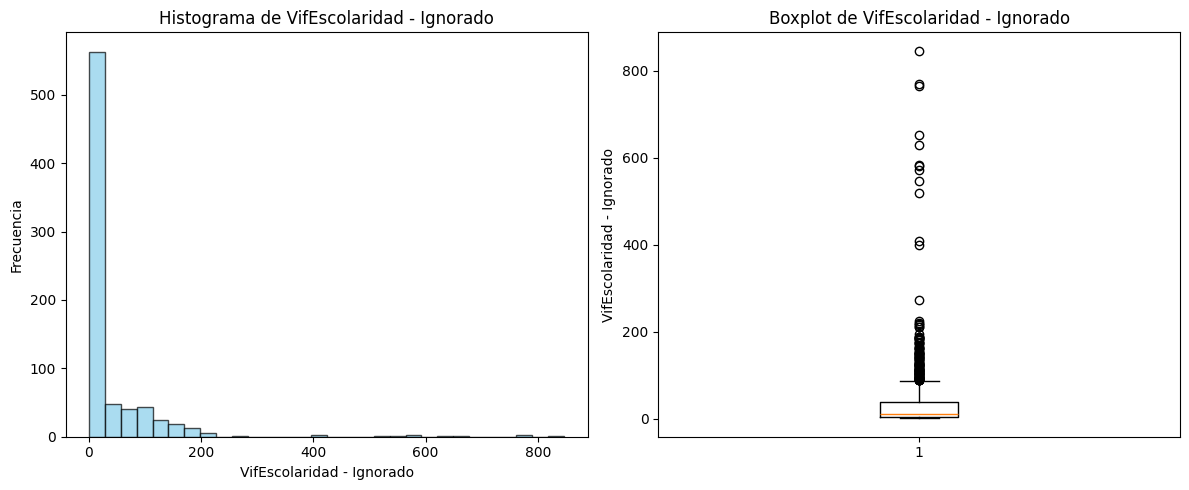

********************************************************************************************

üîπ **Analizando archivo: VifPuebloSexoRelacion**

Estad√≠stico de prueba (ks_statistic) = 0.34157292332588035100
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifPuebloSexoRelacion - Total' NO provienen de una distribuci√≥n normal.



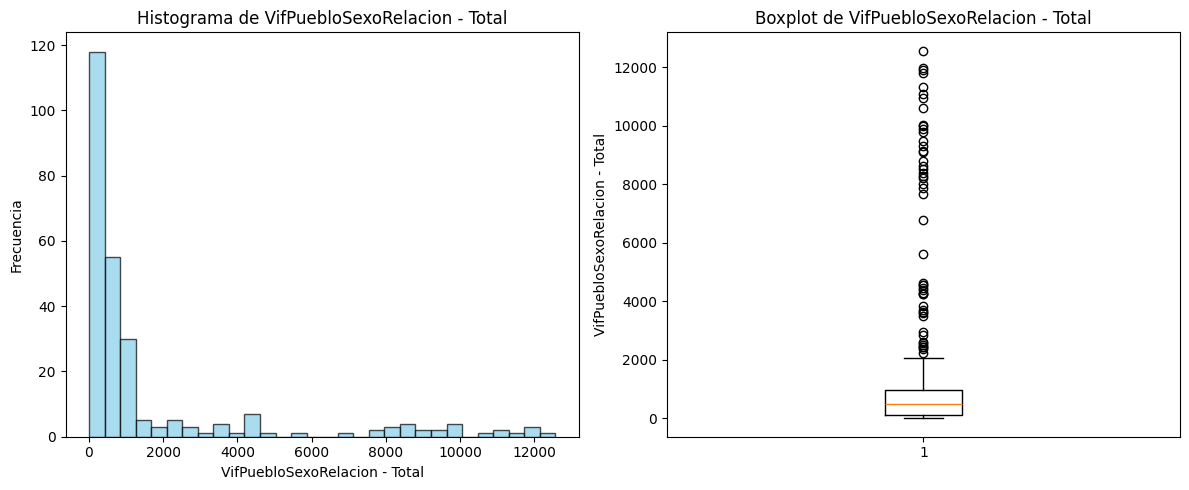

Estad√≠stico de prueba (ks_statistic) = 0.34728655852876011423
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifPuebloSexoRelacion - Ladinos(as)' NO provienen de una distribuci√≥n normal.



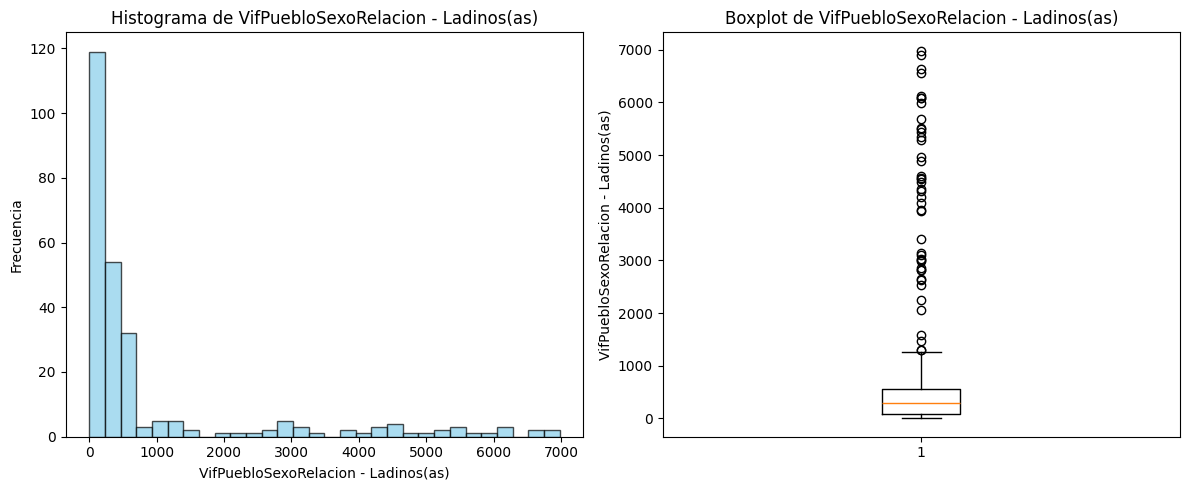

‚ö†Ô∏è La columna 'Mayas' tiene 5 ceros en el archivo 'VifPuebloSexoRelacion'.
Estad√≠stico de prueba (ks_statistic) = 0.31694767916773119998
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifPuebloSexoRelacion - Mayas' NO provienen de una distribuci√≥n normal.



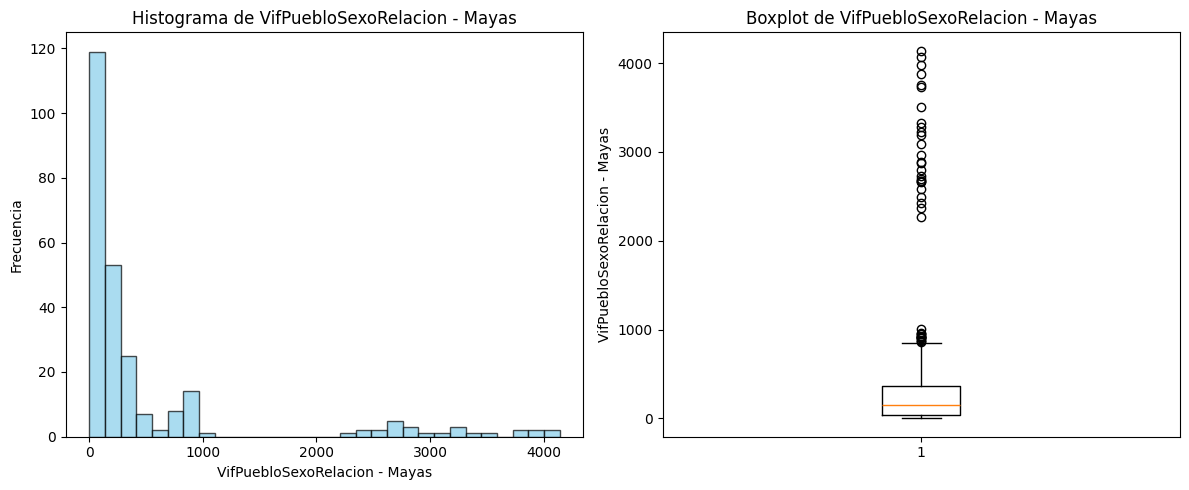

‚ö†Ô∏è La columna 'Gar√≠funas' tiene 138 ceros en el archivo 'VifPuebloSexoRelacion'.
Estad√≠stico de prueba (ks_statistic) = 0.24092571847695964937
p-value = 0.00000102053104664072
Se rechaza la hip√≥tesis nula: los datos de 'VifPuebloSexoRelacion - Gar√≠funas' NO provienen de una distribuci√≥n normal.



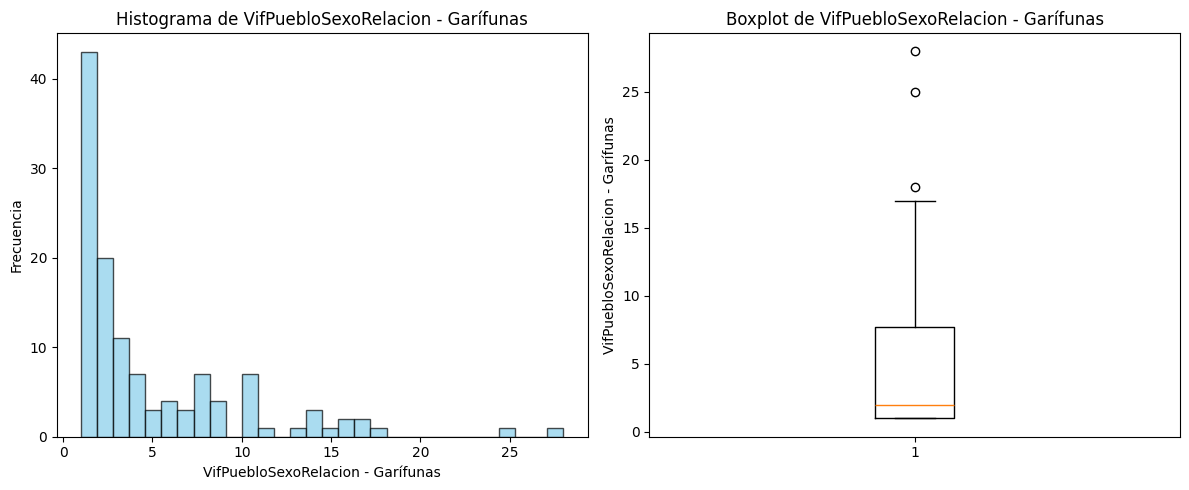

‚ö†Ô∏è La columna 'Xinkas' tiene 138 ceros en el archivo 'VifPuebloSexoRelacion'.
Estad√≠stico de prueba (ks_statistic) = 0.29099678314304600057
p-value = 0.00000000120657717984
Se rechaza la hip√≥tesis nula: los datos de 'VifPuebloSexoRelacion - Xinkas' NO provienen de una distribuci√≥n normal.



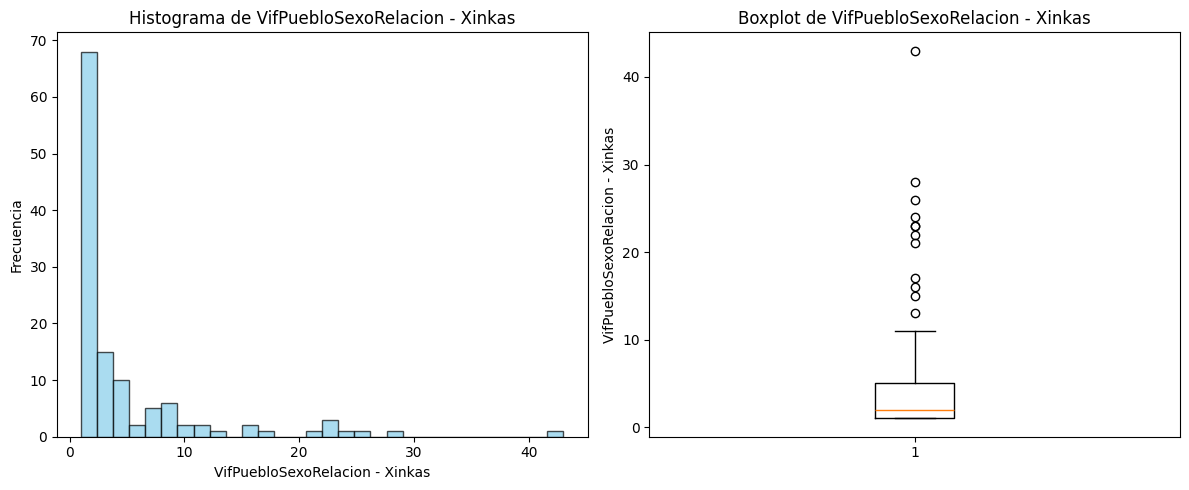

‚ö†Ô∏è La columna 'Otro' tiene 88 ceros en el archivo 'VifPuebloSexoRelacion'.
Estad√≠stico de prueba (ks_statistic) = 0.28673192746887049553
p-value = 0.00000000000051878957
Se rechaza la hip√≥tesis nula: los datos de 'VifPuebloSexoRelacion - Otro' NO provienen de una distribuci√≥n normal.



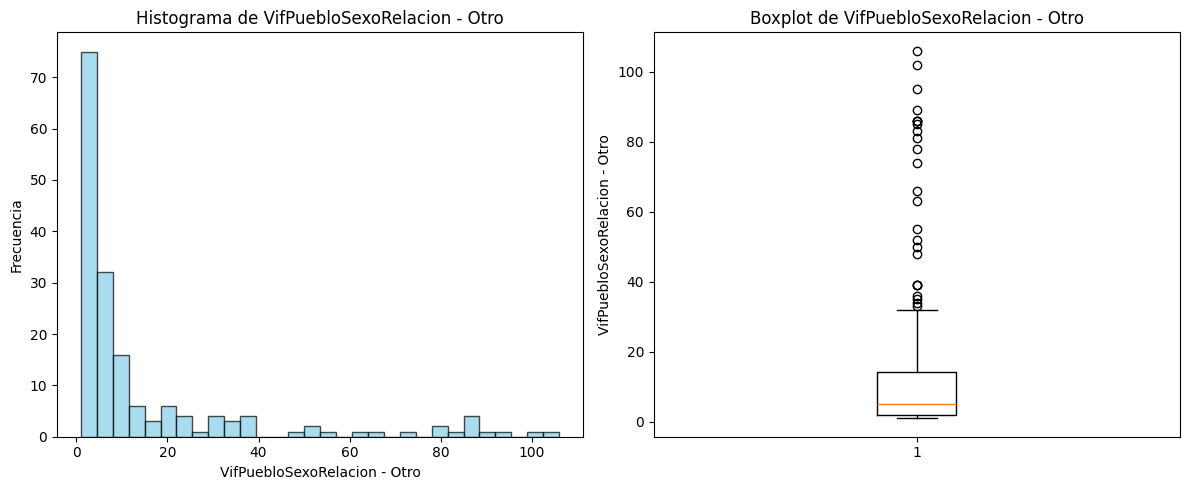

‚ö†Ô∏è La columna 'No indica' tiene 7 ceros en el archivo 'VifPuebloSexoRelacion'.
Estad√≠stico de prueba (ks_statistic) = 0.34086069066334540034
p-value = 0.00000000000000000000
Se rechaza la hip√≥tesis nula: los datos de 'VifPuebloSexoRelacion - No indica' NO provienen de una distribuci√≥n normal.



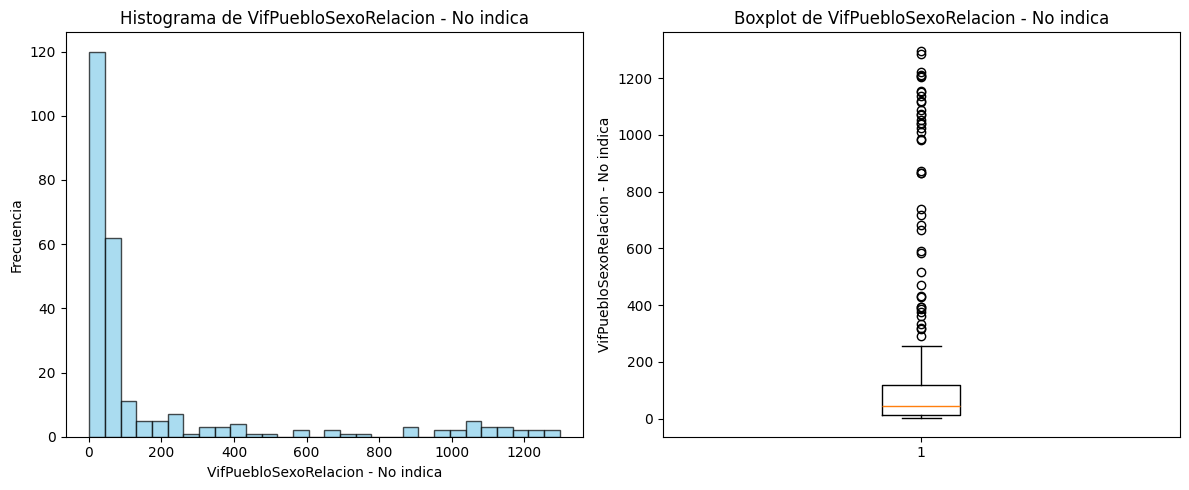

‚ö†Ô∏è La columna 'Ignorado' tiene 32 ceros en el archivo 'VifPuebloSexoRelacion'.
Estad√≠stico de prueba (ks_statistic) = 0.29878973354233095971
p-value = 0.00000000000000000152
Se rechaza la hip√≥tesis nula: los datos de 'VifPuebloSexoRelacion - Ignorado' NO provienen de una distribuci√≥n normal.



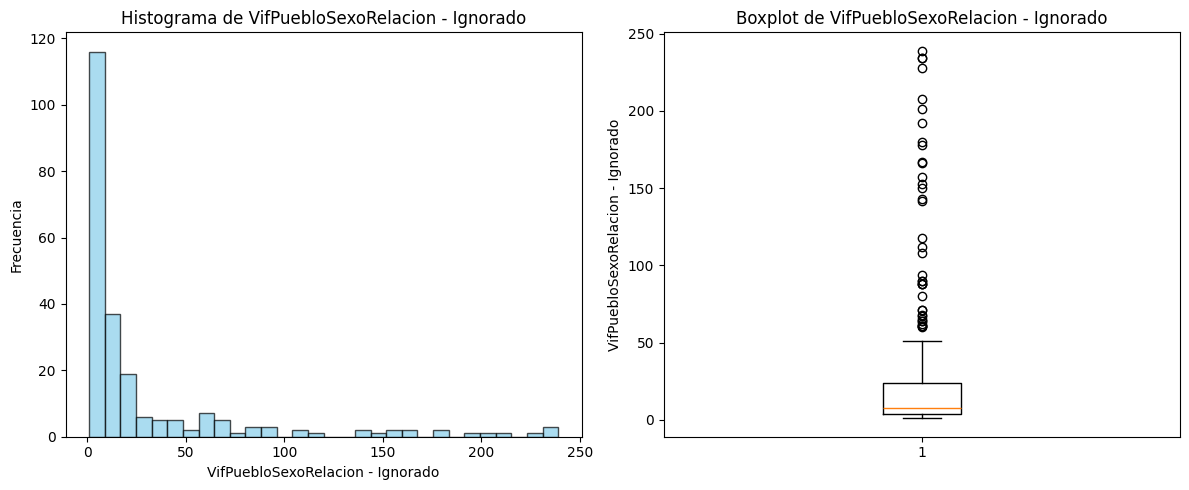

In [141]:
import normalidad

palabras_excluir = ["Total"]

for name, df in dfs.items():
    print("********************************************************************************************")
    print(f"\nüîπ **Analizando archivo: {name}**\n")
    cuantitiativas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cuantitiativas.remove('Anio')
    
   
     # Filtrar filas que contengan "Todos" o "Todas" en cualquier columna categ√≥rica
    df_filtrado = df[~df.select_dtypes(include=[object]).apply(lambda x: x.str.contains('|'.join(palabras_excluir), na=False)).any(axis=1)]
    
    for column in cuantitiativas:  # Solo columnas num√©ricas
        # Contar los ceros en la columna original
        num_zeros = (df_filtrado[column] == 0).sum()
        
        # Mostrar el n√∫mero de ceros
        if num_zeros > 0:
            print(f"‚ö†Ô∏è La columna '{column}' tiene {num_zeros} ceros en el archivo '{name}'.")
        
        # Filtrar los ceros de la columna antes de la prueba
        df_filtrado_column = df_filtrado[column].loc[df_filtrado[column] != 0]
        
        # Realizar la prueba solo si hay datos disponibles despu√©s de filtrar los ceros
        if not df_filtrado_column.empty:
            normalidad.prueba_de_normalidad(df_filtrado_column, f"{name} - {column}")
        else:
            print(f"‚ö†Ô∏è No hay datos suficientes para realizar la prueba de normalidad en '{name} - {column}' despu√©s de eliminar ceros.\n")

       

### Frecuencia


üîπ **Analizando archivo: VifAlfa**




üîπ **Analizando archivo: VifAreaSexoEdad**



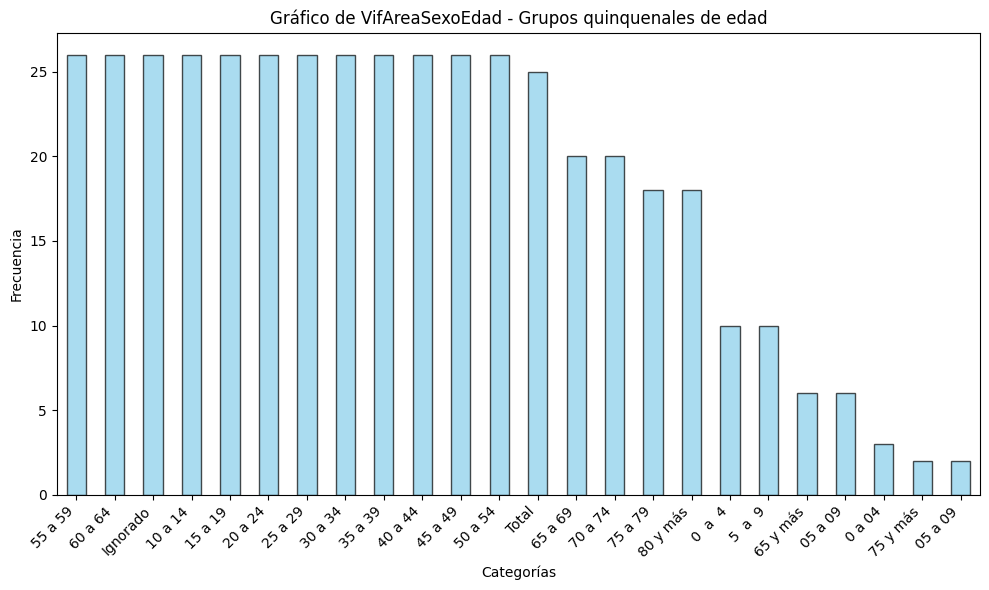

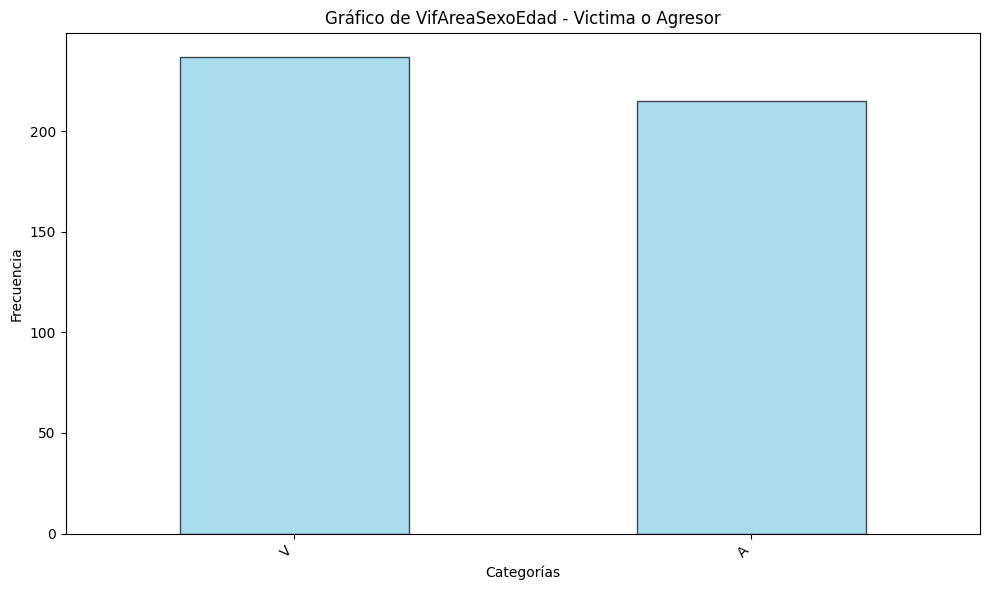

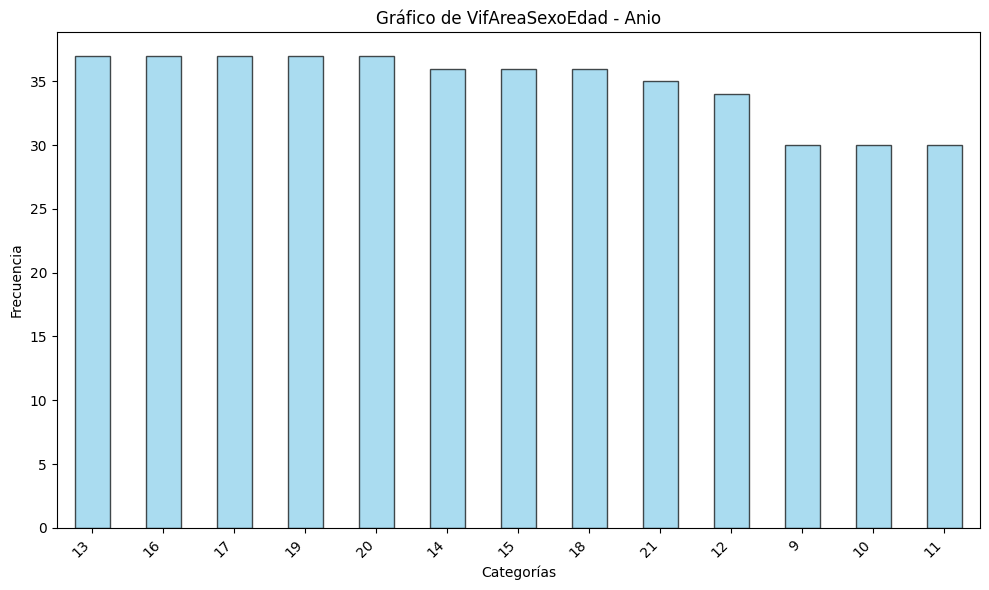


üîπ **Analizando archivo: VifEscolaridad**



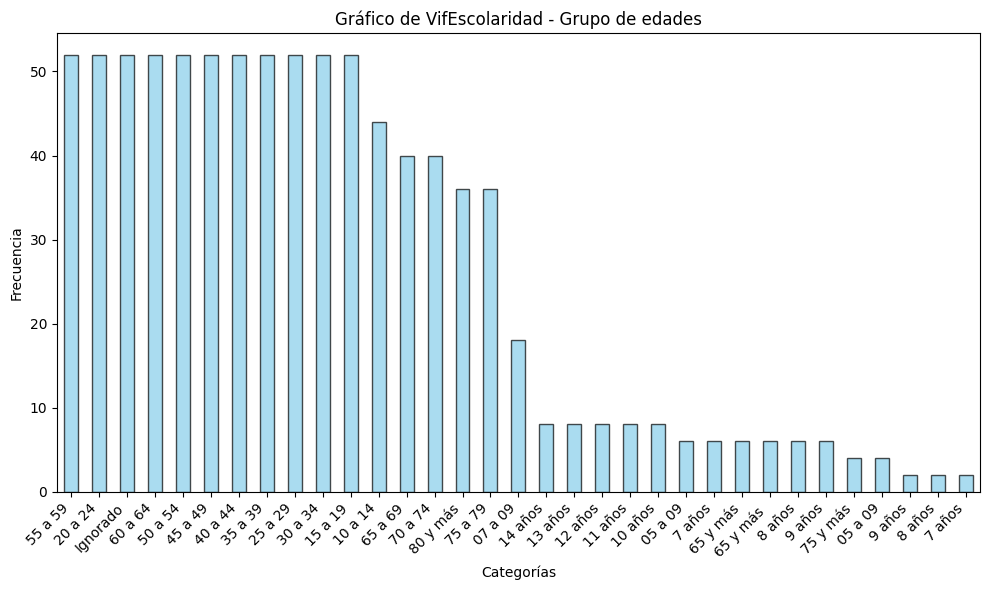

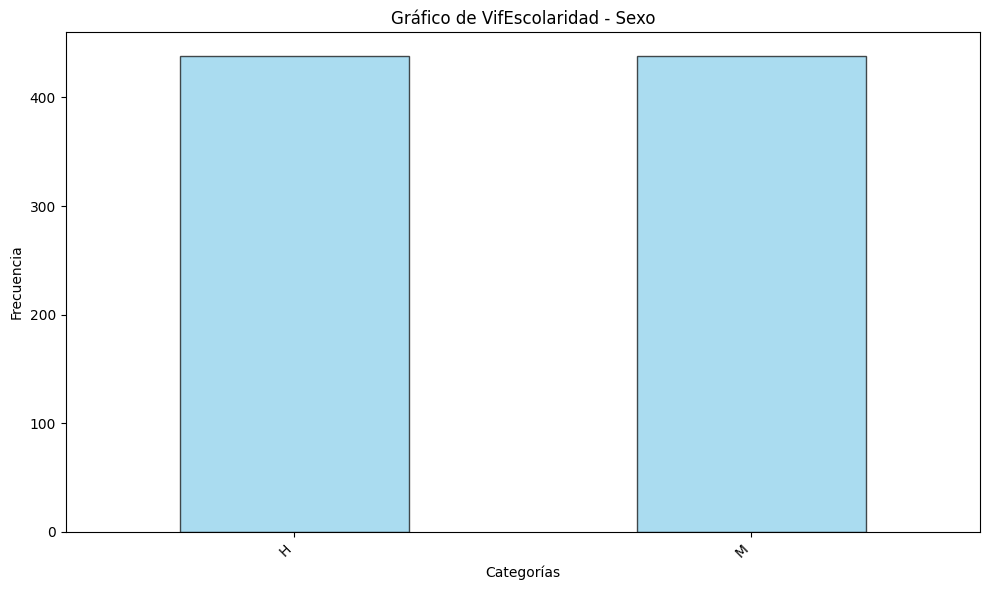

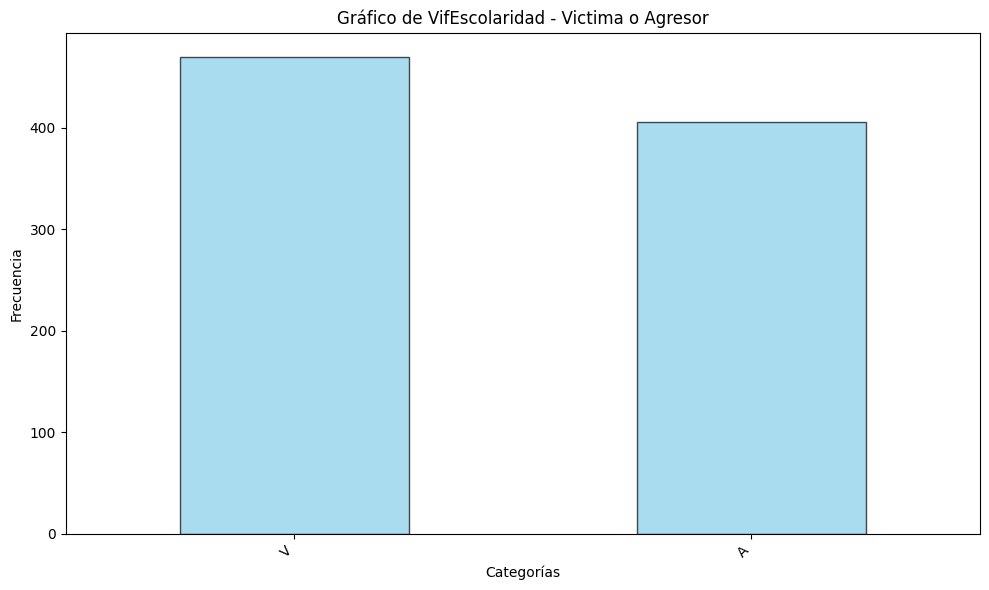

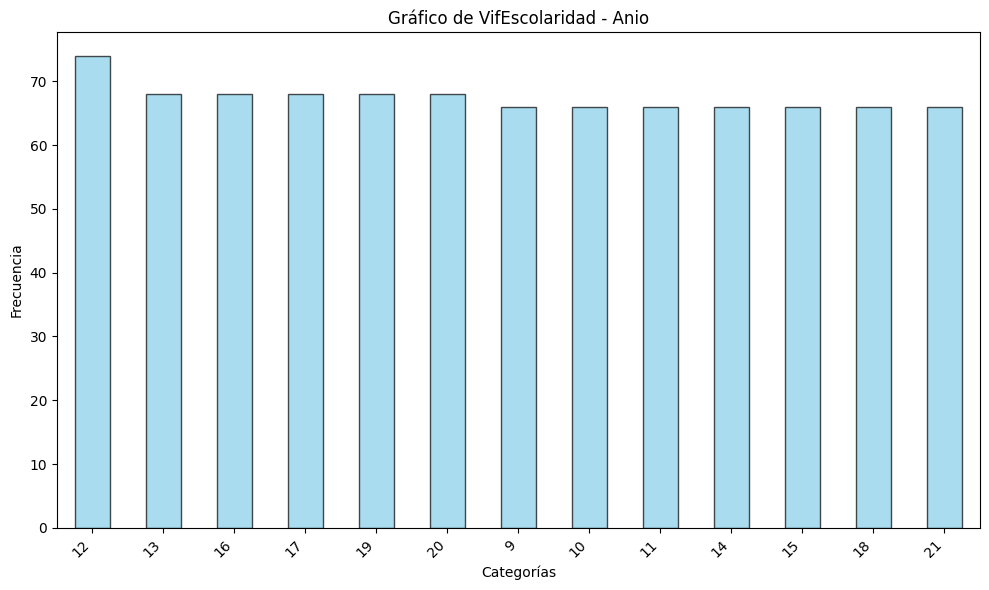


üîπ **Analizando archivo: VifPuebloSexoRelacion**



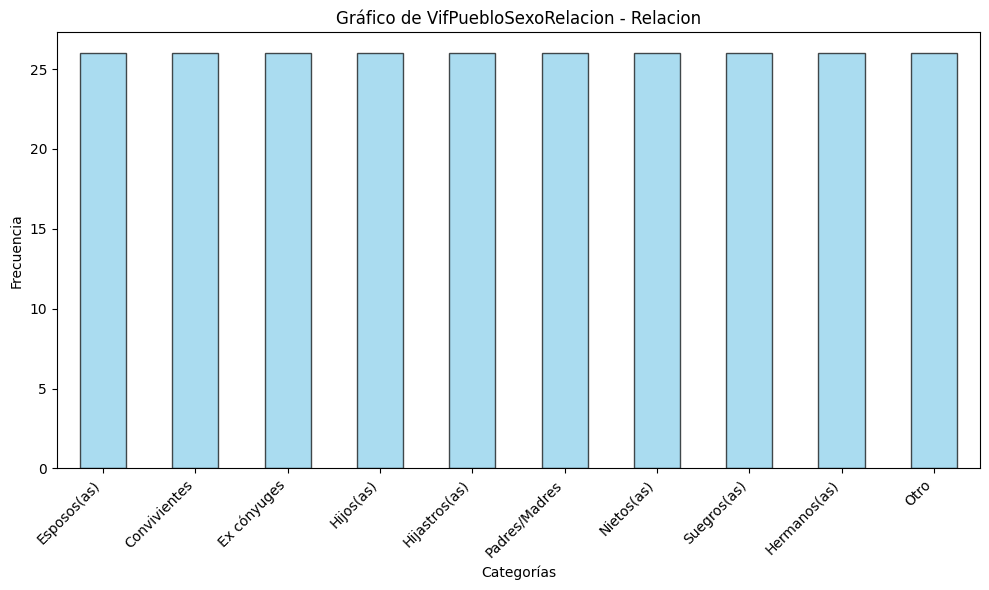

In [142]:
for name, df in dfs.items():
    print(f"\nüîπ **Analizando archivo: {name}**\n")
    cualitativas = df.select_dtypes(include=['object']).columns.tolist()
    cualitativas.append('Anio')
    
    for column in cualitativas:  # Solo columnas num√©ricas
        normalidad.frecuencias(df[column], f"{name} - {column}")

### Gr√°ficos Exploratorios

#### Clusters 

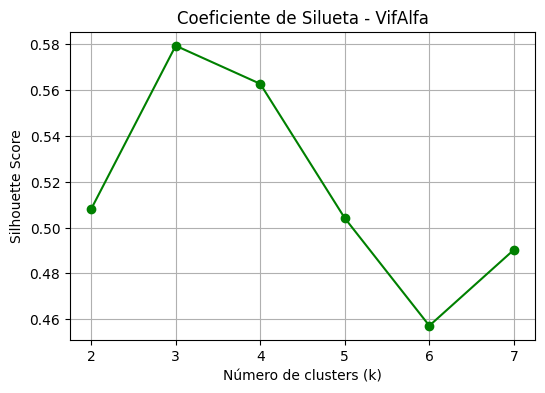

=== Resumen por cluster (valores absolutos) ===


Total  Alfabeta  Analfabeta  Ignorado
cluster                                         
0        61925.1   49604.5     11960.8     359.8
1        33442.5   29286.2      3883.1     273.2
2        43985.3   37242.0      5991.0     752.3

=== Proporciones por cluster ===


Alfabeta  Analfabeta  Ignorado
cluster                                
0            0.80        0.19      0.01
1            0.88        0.12      0.01
2            0.85        0.14      0.02

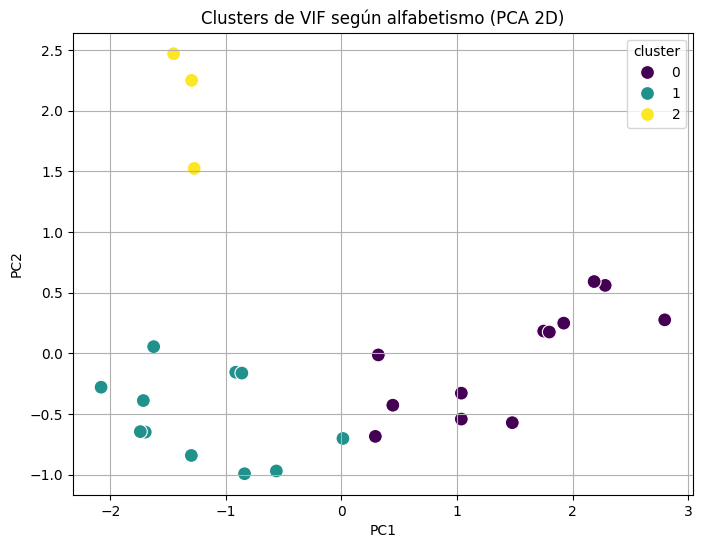

=== Anio y Sexo por cluster ===

Cluster 0:
 - 9 / M
 - 10 / M
 - 11 / M
 - 12 / M
 - 13 / M
 - 14 / M
 - 15 / M
 - 16 / M
 - 17 / M
 - 18 / M
 - 19 / M
 - 20 / M

Cluster 1:
 - 12 / H
 - 13 / H
 - 14 / H
 - 15 / H
 - 16 / H
 - 17 / H
 - 18 / H
 - 19 / H
 - 20 / H
 - 21 / H
 - 21 / M

Cluster 2:
 - 9 / H
 - 10 / H
 - 11 / H


In [143]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar dataframe
df = dfs["VifAlfa"].copy()

# Asegurarse de que las columnas num√©ricas est√©n limpias
cols_num = ["Total", "Alfabeta", "Analfabeta", "Ignorado"]
df[cols_num] = df[cols_num].replace("-", 0)
df[cols_num] = df[cols_num].apply(pd.to_numeric, errors='coerce')

# Agrupar por Anio y Sexo
df_agg = df.groupby(["Anio", "Sexo"], as_index=False)[cols_num].sum()

# Calcular proporciones
X = df_agg[["Alfabeta", "Analfabeta", "Ignorado"]].div(df_agg["Total"], axis=0)

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# M√©todo del codo
inertia = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    inertia.append(km.fit(X_scaled).inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2, 8), inertia, marker="o")
plt.title("M√©todo del Codo - VifAlfa")
plt.xlabel("N√∫mero de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

# Silhouette
scores = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(range(2, 8), scores, marker="o", color="green")
plt.title("Coeficiente de Silueta - VifAlfa")
plt.xlabel("N√∫mero de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Elegir k (puedes ajustar seg√∫n las gr√°ficas)
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_agg["cluster"] = kmeans.fit_predict(X_scaled)

# Resumen por cluster
print("=== Resumen por cluster (valores absolutos) ===")
display(df_agg.groupby("cluster")[["Total", "Alfabeta", "Analfabeta", "Ignorado"]].mean().round(1))

print("=== Proporciones por cluster ===")
props = df_agg.groupby("cluster")[["Alfabeta", "Analfabeta", "Ignorado"]].sum()
props = props.div(props.sum(axis=1), axis=0).round(2)
display(props)

# Visualizaci√≥n PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=df_agg["cluster"], palette="viridis", s=100)
plt.title("Clusters de VIF seg√∫n alfabetismo (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Mostrar datos por cluster
print("=== Anio y Sexo por cluster ===")
for k in sorted(df_agg["cluster"].unique()):
    print(f"\nCluster {k}:")
    filas = df_agg[df_agg["cluster"] == k][["Anio", "Sexo"]]
    for _, row in filas.iterrows():
        print(f" - {int(row['Anio'])} / {row['Sexo']}")


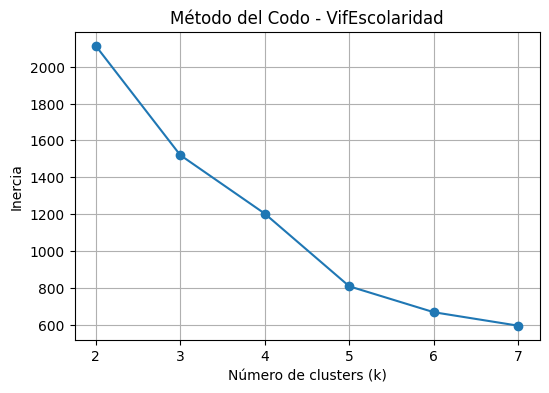

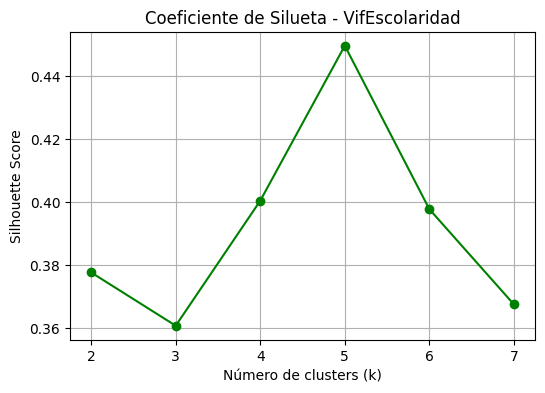

=== Resumen por cluster (valores absolutos) ===


Total  Ninguno  Primaria  B√°sico  Diversificado  Universitario  \
cluster                                                                    
0        3106.8    467.0    1331.6   526.4          576.0           87.6   
1         457.8    189.3     174.8    29.1           42.5           11.0   
2          38.6      3.5      26.3     6.9            0.1            0.0   

         Ignorado  
cluster            
0           118.3  
1            11.2  
2             1.8

=== Proporciones de escolaridad por cluster ===


Ninguno  Primaria  B√°sico  Diversificado  Universitario  Ignorado
cluster                                                                   
0           0.15      0.43    0.17           0.19           0.03      0.04
1           0.41      0.38    0.06           0.09           0.02      0.02
2           0.09      0.68    0.18           0.00           0.00      0.05

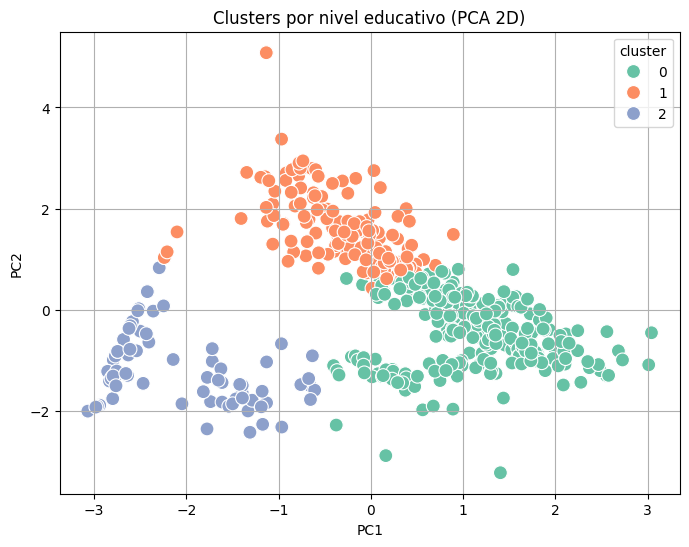

=== Anio, Sexo y Grupo de edades por cluster ===

Cluster 0:
 - 9 / H / 14 a√±os
 - 9 / H / 15 a 19
 - 9 / H / 20 a 24
 - 9 / H / 25 a 29
 - 9 / H / 30 a 34
 - 9 / H / 35 a 39
 - 9 / H / 40 a 44
 - 9 / H / 45 a 49
 - 9 / H / 50 a 54
 - 9 / H / Ignorado
 - 9 / M / 15 a 19
 - 9 / M / 20 a 24
 - 9 / M / 25 a 29
 - 9 / M / 30 a 34
 - 9 / M / 35 a 39
 - 9 / M / 40 a 44
 - 9 / M / Ignorado
 - 10 / H / 15 a 19
 - 10 / H / 20 a 24
 - 10 / H / 25 a 29
 - 10 / H / 30 a 34
 - 10 / H / 35 a 39
 - 10 / H / 40 a 44
 - 10 / H / 45 a 49
 - 10 / H / 50 a 54
 - 10 / H / 55 a 59
 - 10 / H / Ignorado
 - 10 / M / 10 a 14
 - 10 / M / 15 a 19
 - 10 / M / 20 a 24
 - 10 / M / 25 a 29
 - 10 / M / 30 a 34
 - 10 / M / 35 a 39
 - 10 / M / 40 a 44
 - 10 / M / Ignorado
 - 11 / H / 14 a√±os
 - 11 / H / 15 a 19
 - 11 / H / 20 a 24
 - 11 / H / 25 a 29
 - 11 / H / 30 a 34
 - 11 / H / 35 a 39
 - 11 / H / 40 a 44
 - 11 / H / 45 a 49
 - 11 / H / 50 a 54
 - 11 / H / 55 a 59
 - 11 / H / Ignorado
 - 11 / M / 15 a 19
 - 11 / M

In [144]:
# Cargar y preparar
df = dfs["VifEscolaridad"].copy()

# Variables num√©ricas
cols_num = ["Total", "Ninguno", "Primaria", "B√°sico", "Diversificado", "Universitario", "Ignorado"]
df[cols_num] = df[cols_num].replace("-", 0)
df[cols_num] = df[cols_num].apply(pd.to_numeric, errors="coerce")

# Agrupar por Anio, Sexo y Grupo de edades
df_agg = df.groupby(["Anio", "Sexo", "Grupo de edades"], as_index=False)[cols_num].sum()

# Eliminar filas con Total = 0 o NaN
df_agg = df_agg[df_agg["Total"] > 0].dropna(subset=["Total"])

# Calcular proporciones
X = df_agg[["Ninguno", "Primaria", "B√°sico", "Diversificado", "Universitario", "Ignorado"]].div(df_agg["Total"], axis=0)

# Eliminar filas con NaNs resultantes
X = X.dropna()
df_agg = df_agg.loc[X.index]  # mantener sincronizados


# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Asegurar alineaci√≥n de √≠ndices
X = X.reset_index(drop=True)
df_agg = df_agg.reset_index(drop=True)


# M√©todo del codo
inertia = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    inertia.append(km.fit(X_scaled).inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2, 8), inertia, marker="o")
plt.title("M√©todo del Codo - VifEscolaridad")
plt.xlabel("N√∫mero de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

# Silhouette
scores = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(range(2, 8), scores, marker="o", color="green")
plt.title("Coeficiente de Silueta - VifEscolaridad")
plt.xlabel("N√∫mero de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Elegir k (ajustable)
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_agg["cluster"] = kmeans.fit_predict(X_scaled)

# Resumen absoluto por cluster
print("=== Resumen por cluster (valores absolutos) ===")
display(df_agg.groupby("cluster")[cols_num].mean().round(1))

# Proporciones por cluster
props = df_agg.groupby("cluster")[["Ninguno", "Primaria", "B√°sico", "Diversificado", "Universitario", "Ignorado"]].sum()
props = props.div(props.sum(axis=1), axis=0).round(2)
print("=== Proporciones de escolaridad por cluster ===")
display(props)

# Visualizaci√≥n PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=df_agg["cluster"], palette="Set2", s=100)
plt.title("Clusters por nivel educativo (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Mostrar agrupaciones por cluster
print("=== Anio, Sexo y Grupo de edades por cluster ===")
for k in sorted(df_agg["cluster"].unique()):
    print(f"\nCluster {k}:")
    sub = df_agg[df_agg["cluster"] == k][["Anio", "Sexo", "Grupo de edades"]]
    for _, row in sub.iterrows():
        print(f" - {int(row['Anio'])} / {row['Sexo']} / {row['Grupo de edades']}")


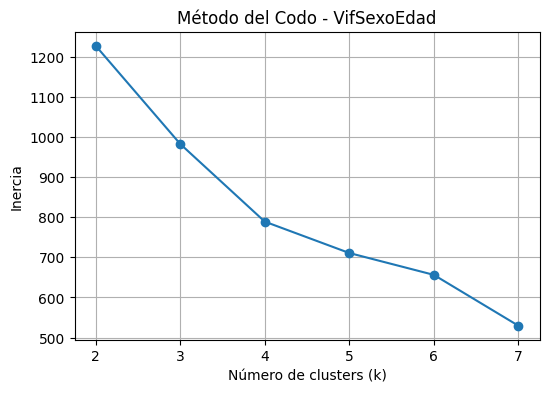

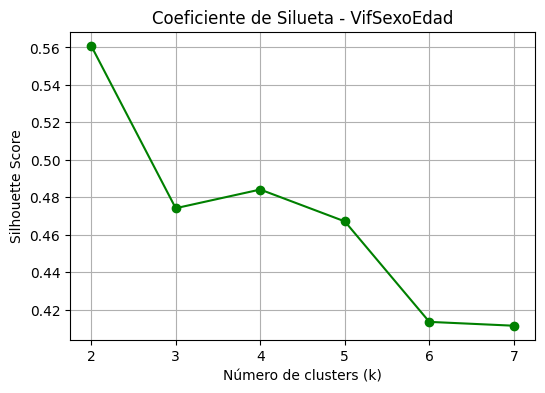

=== Resumen por cluster (valores absolutos) ===


Total   Urban  UrbanH  UrbanM   Rural  RuralH  RuralM
cluster                                                        
0        3916.9  2126.6  1840.2   286.4  1608.1  1411.5   196.6
1        5193.4  2845.5   295.7  2549.8  2103.6   209.8  1893.8
2         902.0   444.7    65.7   378.9   426.1    63.4   362.8

=== Proporciones urbano/rural por cluster ===


Urban  UrbanH  UrbanM  Rural  RuralH  RuralM
cluster                                              
0         0.28    0.25    0.04   0.22    0.19    0.03
1         0.29    0.03    0.26   0.21    0.02    0.19
2         0.26    0.04    0.22   0.24    0.04    0.21

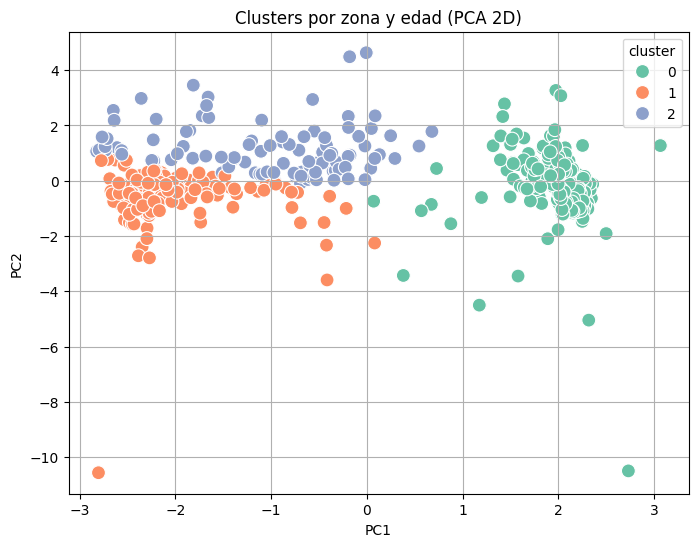

=== Anio, Rol y Grupo de edad por cluster ===

Cluster 0:
 - 9 / A / 15 a 19
 - 9 / A / 20 a 24
 - 9 / A / 25 a 29
 - 9 / A / 30 a 34
 - 9 / A / 35 a 39
 - 9 / A / 40 a 44
 - 9 / A / 45 a 49
 - 9 / A / 50 a 54
 - 9 / A / 55 a 59
 - 9 / A / 60 a 64
 - 9 / A / 65 y m√°s
 - 9 / A / Ignorado
 - 9 / A / Total
 - 10 / A / 15 a 19
 - 10 / A / 20 a 24
 - 10 / A / 25 a 29
 - 10 / A / 30 a 34
 - 10 / A / 35 a 39
 - 10 / A / 40 a 44
 - 10 / A / 45 a 49
 - 10 / A / 50 a 54
 - 10 / A / 55 a 59
 - 10 / A / 60 a 64
 - 10 / A / 65 y m√°s
 - 10 / A / Ignorado
 - 10 / A / Total
 - 11 / A / 15 a 19
 - 11 / A / 20 a 24
 - 11 / A / 25 a 29
 - 11 / A / 30 a 34
 - 11 / A / 35 a 39
 - 11 / A / 40 a 44
 - 11 / A / 45 a 49
 - 11 / A / 50 a 54
 - 11 / A / 55 a 59
 - 11 / A / 60 a 64
 - 11 / A / 65 y m√°s
 - 11 / A / Ignorado
 - 11 / A / Total
 - 12 / A / 15 a 19
 - 12 / A / 20 a 24
 - 12 / A / 25 a 29
 - 12 / A / 30 a 34
 - 12 / A / 35 a 39
 - 12 / A / 40 a 44
 - 12 / A / 45 a 49
 - 12 / A / 50 a 54
 - 12 / A / 

In [145]:
# Cargar y preparar
df = dfs["VifAreaSexoEdad"].copy()

# Variables num√©ricas
cols_num = ["Total", "Urban", "UrbanH", "UrbanM", "Rural", "RuralH", "RuralM"]
df[cols_num] = df[cols_num].replace("-", 0)
df[cols_num] = df[cols_num].apply(pd.to_numeric, errors="coerce")

# Agrupar por Anio, Victima o Agresor y grupo de edad
df_agg = df.groupby(["Anio", "Victima o Agresor", "Grupos quinquenales de edad"], as_index=False)[cols_num].sum()

# Eliminar filas con Total = 0 o NaN
df_agg = df_agg[df_agg["Total"] > 0].dropna(subset=["Total"])

# Calcular proporciones
X = df_agg[["Urban", "UrbanH", "UrbanM", "Rural", "RuralH", "RuralM"]].div(df_agg["Total"], axis=0)

# Asegurar sincronizaci√≥n de √≠ndices
X = X.dropna()
df_agg = df_agg.loc[X.index]
X = X.reset_index(drop=True)
df_agg = df_agg.reset_index(drop=True)

# M√©todo del codo
inertia = []
X_scaled = StandardScaler().fit_transform(X)
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    inertia.append(km.fit(X_scaled).inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2, 8), inertia, marker="o")
plt.title("M√©todo del Codo - VifSexoEdad")
plt.xlabel("N√∫mero de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

# Silhouette Score
scores = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(range(2, 8), scores, marker="o", color="green")
plt.title("Coeficiente de Silueta - VifSexoEdad")
plt.xlabel("N√∫mero de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Elegir mejor k
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_agg["cluster"] = kmeans.fit_predict(X_scaled)

# Resumen absoluto por cluster
print("=== Resumen por cluster (valores absolutos) ===")
display(df_agg.groupby("cluster")[cols_num].mean().round(1))

# Proporciones por cluster
props = df_agg.groupby("cluster")[["Urban", "UrbanH", "UrbanM", "Rural", "RuralH", "RuralM"]].sum()
props = props.div(props.sum(axis=1), axis=0).round(2)
print("=== Proporciones urbano/rural por cluster ===")
display(props)

# Visualizaci√≥n PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=df_agg["cluster"], palette="Set2", s=100)
plt.title("Clusters por zona y edad (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Mostrar agrupaciones por cluster
print("=== Anio, Rol y Grupo de edad por cluster ===")
for k in sorted(df_agg["cluster"].unique()):
    print(f"\nCluster {k}:")
    sub = df_agg[df_agg["cluster"] == k][["Anio", "Victima o Agresor", "Grupos quinquenales de edad"]]
    for _, row in sub.iterrows():
        print(f" - {int(row['Anio'])} / {row['Victima o Agresor']} / {row['Grupos quinquenales de edad']}")


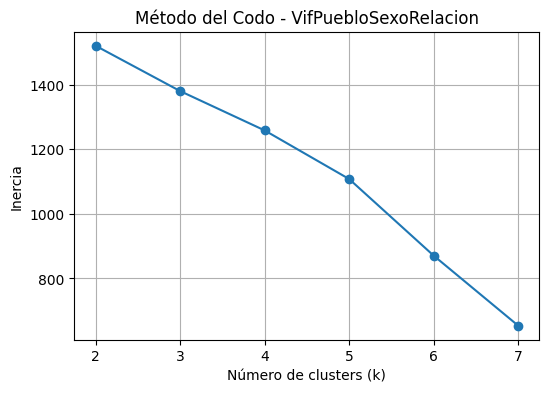

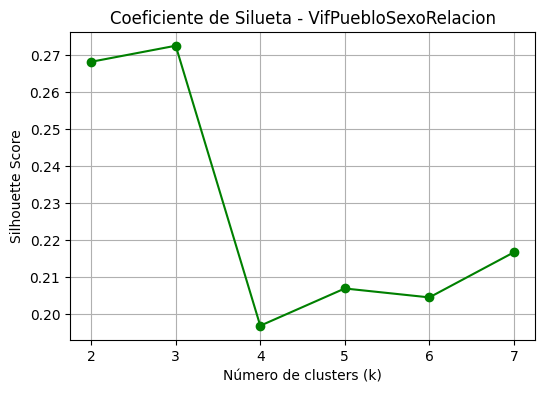

=== Resumen por cluster (valores absolutos) ===


Ladinos(as)  Mayas  Gar√≠funas  Xinkas  Otro  No indica  Ignorado  \
cluster                                                                     
0             1089.9  657.2        2.5     3.0  12.0      221.0      31.7   
1              600.8  184.1        1.8     1.0   6.5       86.3      14.0   
2                2.0    0.0        0.0     0.0   0.0        1.0       1.0   

          Total  
cluster          
0        2017.4  
1         894.5  
2           4.0

=== Proporciones por grupo √©tnico por cluster ===


Ladinos(as)  Mayas  Gar√≠funas  Xinkas  Otro  No indica  Ignorado
cluster                                                                  
0               0.54   0.33        0.0     0.0  0.01       0.11      0.02
1               0.67   0.21        0.0     0.0  0.01       0.10      0.02
2               0.50   0.00        0.0     0.0  0.00       0.25      0.25

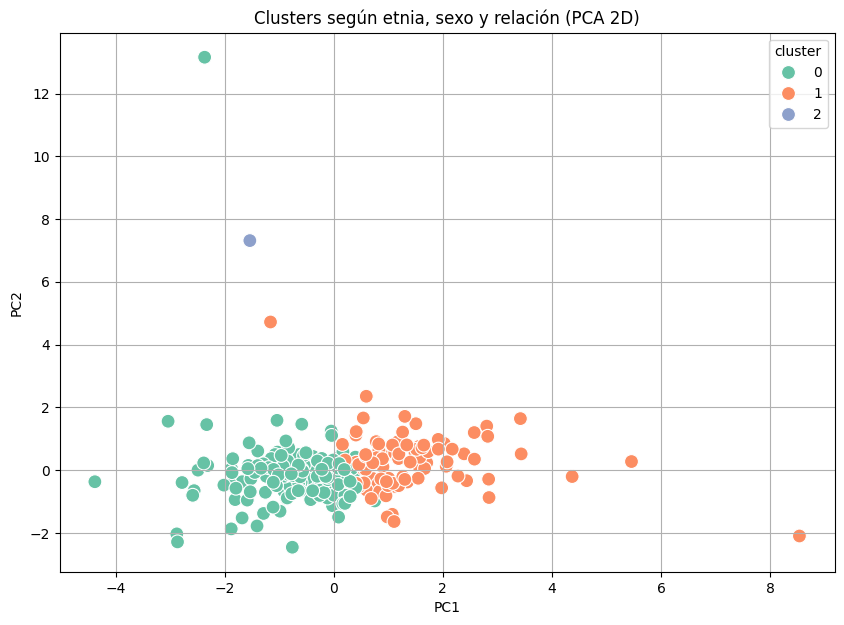

=== A√±o, Sexo y Relaci√≥n por cluster ===

Cluster 0:
 - 9 / H / Hermanos(as)
 - 9 / H / Otro
 - 9 / H / Padres/Madres
 - 9 / H / Suegros(as)
 - 9 / M / Convivientes
 - 9 / M / Esposos(as)
 - 9 / M / Hermanos(as)
 - 9 / M / Hijastros(as)
 - 9 / M / Padres/Madres
 - 10 / H / Hermanos(as)
 - 10 / H / Hijos(as)
 - 10 / H / Otro
 - 10 / H / Padres/Madres
 - 10 / H / Suegros(as)
 - 10 / M / Convivientes
 - 10 / M / Esposos(as)
 - 10 / M / Hermanos(as)
 - 10 / M / Hijos(as)
 - 10 / M / Otro
 - 10 / M / Padres/Madres
 - 11 / H / Convivientes
 - 11 / H / Hermanos(as)
 - 11 / H / Otro
 - 11 / H / Padres/Madres
 - 11 / H / Suegros(as)
 - 11 / M / Convivientes
 - 11 / M / Esposos(as)
 - 11 / M / Hermanos(as)
 - 11 / M / Nietos(as)
 - 11 / M / Otro
 - 11 / M / Padres/Madres
 - 11 / M / Suegros(as)
 - 12 / H / Hermanos(as)
 - 12 / H / Hijastros(as)
 - 12 / H / Hijos(as)
 - 12 / H / Otro
 - 12 / H / Padres/Madres
 - 12 / M / Convivientes
 - 12 / M / Esposos(as)
 - 12 / M / Hermanos(as)
 - 12 / M / 

In [146]:
# Cargar el dataset
df = dfs["VifPuebloSexoRelacion"].copy()

# Variables √©tnicas
cols_etnia = ["Ladinos(as)", "Mayas", "Gar√≠funas", "Xinkas", "Otro", "No indica", "Ignorado"]
df[cols_etnia + ["Total"]] = df[cols_etnia + ["Total"]].replace("-", 0)
df[cols_etnia + ["Total"]] = df[cols_etnia + ["Total"]].apply(pd.to_numeric, errors="coerce")

# Agrupar por Anio, Sexo y Relaci√≥n
df_agg = df.groupby(["Anio", "Sexo", "Relacion"], as_index=False)[cols_etnia + ["Total"]].sum()

# Eliminar entradas sin total o con NaN
df_agg = df_agg[df_agg["Total"] > 0].dropna(subset=["Total"])

# Calcular proporciones por grupo √©tnico
X = df_agg[cols_etnia].div(df_agg["Total"], axis=0)

# Alinear con df_agg
X = X.dropna()
df_agg = df_agg.loc[X.index].reset_index(drop=True)
X = X.reset_index(drop=True)

# Escalado
X_scaled = StandardScaler().fit_transform(X)

# M√©todo del codo
inertia = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    inertia.append(km.fit(X_scaled).inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2, 8), inertia, marker="o")
plt.title("M√©todo del Codo - VifPuebloSexoRelacion")
plt.xlabel("N√∫mero de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

# Silhouette Score
scores = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(range(2, 8), scores, marker="o", color="green")
plt.title("Coeficiente de Silueta - VifPuebloSexoRelacion")
plt.xlabel("N√∫mero de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Clustering final
k_optimo = 3  # (ajustar si el gr√°fico lo sugiere)
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_agg["cluster"] = kmeans.fit_predict(X_scaled)

# Resumen de valores absolutos
print("=== Resumen por cluster (valores absolutos) ===")
display(df_agg.groupby("cluster")[cols_etnia + ["Total"]].mean().round(1))

# Proporciones √©tnicas por cluster
proporciones = df_agg.groupby("cluster")[cols_etnia].sum()
proporciones = proporciones.div(proporciones.sum(axis=1), axis=0).round(2)
print("=== Proporciones por grupo √©tnico por cluster ===")
display(proporciones)

# PCA para visualizaci√≥n
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=df_agg["cluster"], palette="Set2", s=100)
plt.title("Clusters seg√∫n etnia, sexo y relaci√≥n (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Mostrar combinaciones por cluster
print("=== A√±o, Sexo y Relaci√≥n por cluster ===")
for k in sorted(df_agg["cluster"].unique()):
    print(f"\nCluster {k}:")
    sub = df_agg[df_agg["cluster"] == k][["Anio", "Sexo", "Relacion"]]
    for _, row in sub.iterrows():
        print(f" - {int(row['Anio'])} / {row['Sexo']} / {row['Relacion']}")
